In [79]:
from sklearn.metrics import mean_squared_error

import csv
import os
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np

## Logarithmic normalization 
- the data should be normalized to get the best results 

In [80]:
def log(data):
    return [np.log(val) for val in data]

## Min Max Normalization

In [81]:
def min_max_normalize(data):
    # Check if data is a single value
    if isinstance(data, (int, float)):
        return data
    else:
        # Perform min-max normalization for a list of values
        min_val = min(data)
        max_val = max(data)
        if max_val == min_val:
            return [min_val] * len(data)
        return [(val - min_val) / (max_val - min_val) for val in data]

## Loading Data
- we get the data from the csv for the coressponding variables
- firstly if there is no value for that field we will replace it with the average of others
- we will min-max or log normalize the data
- return: the data we need

In [82]:


def load_Data(fileName, inputVariableName, outputVariableName):
    data = []
    dataNames = []

    with open(fileName) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                dataNames = row
                line_count += 1
            else:
                data.append(row)
                line_count += 1

    selectedVariables = [dataNames.index(var) for var in inputVariableName]

    # Initialize sums list to hold sum of each variable
    sums = [0 for i in range(len(data[0])+1)]
    count=0
    # Replace empty strings with NaN values and calculate column-wise sums
    for var in selectedVariables:
        for i in range(len(data)):
            if data[i][var] == '':
                data[i][var] = np.nan
            else:
                sums[var] += float(data[i][var])
                data[i][var] = float(data[i][var])
                count+=1
        sums[var] /= count  # Calculate column-wise average

    # Replace NaN values with column-wise average
    for var in selectedVariables:
        for i in range(len(data)):
            if np.isnan(data[i][var]):
                data[i][var] = sums[var]

    # Extract input data
    inputs = [min_max_normalize([float(data[i][var]) for i in range(len(data))]) for var in selectedVariables]
    #inputs = [log([float(data[i][var]) for i in range(len(data))]) for var in selectedVariables]

    # Extract output data
    selectedOutput = dataNames.index(outputVariableName)
    outputs = [float(data[i][selectedOutput]) for i in range(len(data))]

    return inputs, outputs


### Plotting a data's histogram

In [83]:
def ploatDataHistogram(data,attributeName):
    plt.title('Histogram of '+attributeName)
    n,bins,patches=plt.hist(data,10,facecolor='green',alpha=0.5)
    plt.show()

### Checking linearity between data
- it works for both univariate and bivariate
- it shows the datas and how they look together

In [84]:
def check_linarity_between_two_data(data1,data2,attributes,attribute2):
    #print(data1,data2)
    if(len(data1)!=1):
        plotData(data1, data2,  title=attributes[0]+' and '+attributes[1] + ' vs ' + attribute2, label1='train data')
    else:
        plotData(data1, data2, [], [], [], [], attributes[0] + ' vs ' + attribute2, 'train data', )

## Plotting the given data


In [85]:
def plotData(trainX, trainY, learntX=[], learntY=[], testX=[], testY=[], title='', label1=None, label2=None, label3=None):
    # Plot training data
    if isinstance(trainX[0], list):
        if len(trainX[0]) == 2:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            x1 = [el[0] for el in trainX]
            x2 = [el[1] for el in trainX]
            ax.scatter(x1, x2, trainY, c='r', marker='o', label=label1)
        else:
            for v in trainX:
                plt.plot(v, trainY, 'ro', label=label1)
    else:
        plt.plot(trainX, trainY, 'ro', label=label1)

    # Plot learned model
    if len(learntX) > 0:
        if isinstance(learntX[0], list):
            if len(learntX[0]) == 2:
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                x1 = [el[0] for el in learntX]
                x2 = [el[1] for el in learntX]
                ax.scatter(x1, x2, learntY, c='b', marker='o', label=label2)
            else:
                for v in learntX:
                    plt.plot(v, learntY, 'bo', label=label2)
        else:
            plt.plot(learntX, learntY, 'bo', label=label2)

    # Plot testing data
    if len(testX) > 0:
        if isinstance(testX[0], list):
            if len(testX[0]) == 2:
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                x1 = [el[0] for el in testX]
                x2 = [el[1] for el in testX]
                ax.scatter(x1, x2, testY, c='g', marker='^', label=label3)
            else:
                for v in testX:
                    plt.plot(v, testY, 'g^', label=label3)
        else:
            plt.plot(testX, testY, 'g^', label=label3)

    plt.title(title)
    plt.legend()
    plt.show()

## Getting training and validation data

In [86]:

#works for one or more input attributes
def split_data_into_training_and_testing(inputs, outputs, percentage):
    np.random.seed(5)
    indexes = np.random.permutation(len(inputs[0]))
    trainSample = np.random.choice(indexes, int(percentage * len(indexes)),replace=False)
    validationSample = np.setdiff1d(indexes, trainSample)

    if (len(inputs)>1):  # Two input attributes
        trainInputs = [[inputs[0][i], inputs[1][i]] for i in trainSample]
        validationInputs = [[inputs[0][i], inputs[1][i]] for i in validationSample]
    else:  # One input attribute
        trainInputs = [inputs[0][i] for i in trainSample]
        validationInputs = [inputs[0][i] for i in validationSample]

    trainOutputs = [outputs[i] for i in trainSample]
    validationOutputs = [outputs[i] for i in validationSample]

    return trainInputs, trainOutputs, validationInputs, validationOutputs



## Self Linear Regression
### class where you can get the prediction and cofficients


In [87]:
class MyUnivariateRegression:
    def __init__(self):
        self.intercept_ = 0.0
        self.coef_ = 0.0
    def fit(self,x,y):
        sx=sum(x)
        sy=sum(y)
        sx2 = sum(i * i for i in x) #suma de patrate
        sxy = sum(i * j for (i, j) in zip(x, y)) #produs scalar
        w1 = (len(x) * sxy - sx * sy) / (len(x) * sx2 - sx * sx)
        w0 = (sy - w1 * sx) / len(x)
        self.intercept_, self.coef_ = w0, w1
    def predict(self, x):
        if (isinstance(x[0], list)):
            return [self.intercept_ + self.coef_ * val[0] for val in x]
        else:
            return [self.intercept_ + self.coef_ * val for val in x]



## Train model with sklearn

get the coefficients and regressor through sklearn

In [88]:
def train_Model(inputs, outputs):
    #first is it the two atr method or not?
    if (len(inputs) > 1 and isinstance(inputs[0], list)):
        # Prepare input features for the model
        xx = inputs
    else:
        # If there's only one input attribute
        xx = [[x] for x in inputs]

    #init model
    regressor = linear_model.LinearRegression()

    #train
    regressor.fit(xx, outputs)

    # coef
    w0 = regressor.intercept_
    if(len(inputs)>1 and isinstance(inputs[0],list)):
        w1, w2 = regressor.coef_
    else:
        w1,w2=regressor.coef_[0],None

    return w0, w1, w2, regressor

## Plotting learnt model

In [89]:

def plot_learnt_model(inputs, outputs, w0, w1, w2=None):
    noOfPoints = 1000
    if len(inputs)>1 and isinstance(inputs[0],list):  # Two input attributes
        x1 = [inp[0] for inp in inputs]
        x2 = [inp[1] for inp in inputs]
        min_x1, max_x1 = min(x1), max(x1)
        min_x2, max_x2 = min(x2), max(x2)
        step_x1 = (max_x1 - min_x1) / noOfPoints
        step_x2 = (max_x2 - min_x2) / noOfPoints
        x1_ref = [min_x1 + i * step_x1 for i in range(noOfPoints)]
        x2_ref = [min_x2 + i * step_x2 for i in range(noOfPoints)]
        xx_ref = [[x1_val, x2_val] for x1_val, x2_val in zip(x1_ref, x2_ref)]
    else:  # One input attribute
        min_x = min(inputs)
        max_x = max(inputs)
        step = (max_x - min_x) / noOfPoints
        x_ref = [min_x + i * step for i in range(noOfPoints)]
        xx_ref = [[x_val] for x_val in x_ref]

    if w2 is None:  # One input attribute
        y_ref = [w0 + w1 * x[0] for x in xx_ref]
    else:  # Two input attributes
        y_ref = [w0 + w1 * x[0] + w2 * x[1] for x in xx_ref]

    if len(inputs)>1 and isinstance(inputs[0],list):  # Two input attributes
        plotData(inputs, outputs, learntX=[x1_ref,x2_ref], learntY=y_ref, title='Train data and model',
                 label1='Train data', label2='Learned Model')
    else:  # One input attribute
        plotData(inputs, outputs, learntX=[x_ref], learntY=y_ref, title='Train data and model', label1='Train data',
                 label2='Learned Model')


Self Linear Regression
class where you can get the prediction and cofficients

In [90]:
class MyBivariateRegression:
    def __init__(self):
        self.intercept_ = 0.0
        self.coef_ = [0.0, 0.0]  # Coefficients for two attributes

    def fit(self, x1, x2, y):
        n = len(x1)
        sum_x1 = sum(x1)
        sum_x2 = sum(x2)
        sum_y = sum(y)
        sum_x1_sq = sum(val ** 2 for val in x1)
        sum_x1y = sum(val1 * val2 for val1, val2 in zip(x1, y))

        denominator = n * sum_x1_sq - sum_x1 ** 2
        w1 = (n * sum_x1y - sum_x1 * sum_y) / denominator
        w2 = (sum_x1_sq * sum_y - sum_x1 * sum_x1y) / denominator
        w0 = (sum_y - w1 * sum_x1 - w2 * sum_x2) / n

        self.intercept_ = w0
        self.coef_ = [w1, w2]

    def predict(self, x1, x2):
        w0 = self.intercept_
        w1, w2 = self.coef_
        return [w0 + w1 * val1 + w2 * val2 for val1, val2 in zip(x1, x2)]



## Get preddicted out from Sqlearn regressor

In [91]:
def plotPredictedData(validationInputs,computedValOut,validationOutputs):
    if len(validationInputs)>1 and isinstance(validationInputs[0],list):  # Two input attributes
        plotData(validationInputs,computedValOut,[],[],validationInputs,validationOutputs,'Computed vs Real Test Data')
    else:  # One input attribute
        plotData(validationInputs,computedValOut,[],[],validationInputs,validationOutputs,'Computed vs Real Test Data')

In [92]:
def pred(validationInputs, validationOutputs, regressor):
    if len(validationInputs)>1 and isinstance(validationInputs[0],list):  # Two input attributes
        computedValOut = regressor.predict(validationInputs)
    else:  # One input attribute
        computedValOut = regressor.predict([[el] for el in validationInputs])
    return computedValOut

## Differences between predicted output and real output

In [51]:
def differences_pred_vs_real(compValOut,valOut):
    #manual tool
    error=0.0
    for t1,t2 in zip(compValOut,valOut):
        error+=(t1-t2)**2
    error/=len(valOut)
    #acum tool
    mean_error=error=mean_squared_error(valOut,compValOut)
    return error,mean_error

## My linear prediction

In [52]:
def my_linear_prediction(trainInputs,trainOutputs,validationInputs):
    #daca e de o linie
    w2=None
    if not isinstance(trainInputs[0],list):
        myuniv = MyUnivariateRegression()
        myuniv.fit(trainInputs, trainOutputs)
        computed= myuniv.predict(validationInputs)
        w0= myuniv.intercept_
        w1 = myuniv.coef_
    else:
        myuniv = MyBivariateRegression()
        myuniv.fit([x[0] for x in trainInputs], [x[1] for x in trainInputs], trainOutputs)
        computed = myuniv.predict([x[0] for x in validationInputs], [x[1] for x in validationInputs])
        w0 = myuniv.intercept_
        w1, w2 = myuniv.coef_
    return computed,w0,w1,w2

## Linear regression function that goes through everything needed

In [93]:
def linear_Regression(inputAtributes,outputAtr,filePath,mode='sklearn'):
    inputs,outputs=load_Data(filePath,inputAtributes,outputAtr)
    i=0
    for atr in inputAtributes:
        ploatDataHistogram(inputs[i],atr)
        i+=1
    ploatDataHistogram(outputs,outputAtr)
    #acm linearitate
    print('Seeing linearity betweenObjects')
    check_linarity_between_two_data(inputs,outputs,inputAtributes,outputAtr)
    #split data
    split=0.8
    trainInputs,trainOutputs,validationInputs,validationOutputs=split_data_into_training_and_testing(inputs,outputs,split)
    #plot training and test data
    print('Ploating testData')
    plotData(trainInputs,trainOutputs,[],[],validationInputs,validationOutputs,'Training and Testing Data')
    computed = None
    # training the model
    if (mode == 'sklearn'):
        w0, w1, w2, regressor = train_Model(trainInputs, trainOutputs)
        computed = pred(validationInputs, validationOutputs, regressor)
    if (mode == 'self_made'):
        computed,w0,w1,w2 = my_linear_prediction(trainInputs, trainOutputs, validationInputs)
    #plot the learned model
    if(w2!=None):
        print(f'f(x)={w0}+{w1}*x1+{w2}*x2')
    else:
        print(f'f(x)={w0}+{w1}*x1')
    #plot the learned model
    print('Plot the learnt mode:')
    plot_learnt_model(trainInputs,trainOutputs,w0,w1,w2)
    #predict new inputs
    print('Computed:', computed)
    plotPredictedData(validationInputs, computed, validationOutputs)
    #compute the error
    error,tool_er=differences_pred_vs_real(computed,validationOutputs)
    print('Error:',error)
    print('Tool Error:',tool_er)


In [94]:
def linear_prediction_tool(inputAttributes,outputAttribute,file_name,modes='sklearn'):
    crtDir = os.getcwd()
    file_we_are_working_with = file_name
    filePath = os.path.join(crtDir, 'data', file_we_are_working_with)
    linear_Regression(inputAttributes,outputAttribute,filePath)


In [95]:
print('For file v1_world-happiness-report-2017.csv')
print('With tool sklearn')

For file v1_world-happiness-report-2017.csv
With tool sklearn


## TOOL - economy

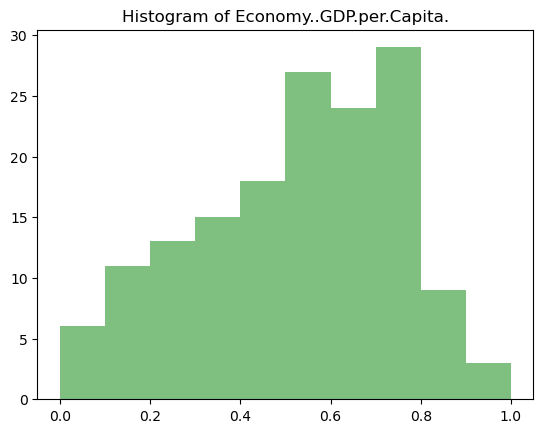

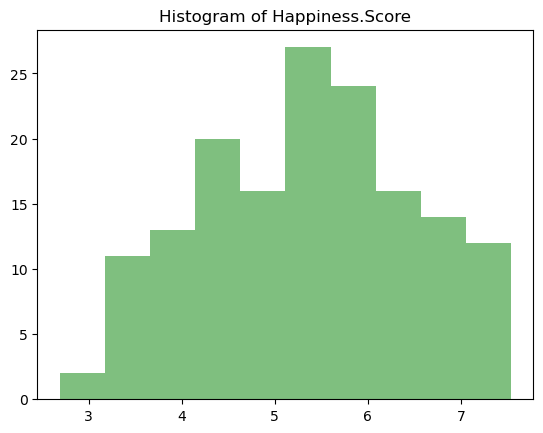

Seeing linearity betweenObjects


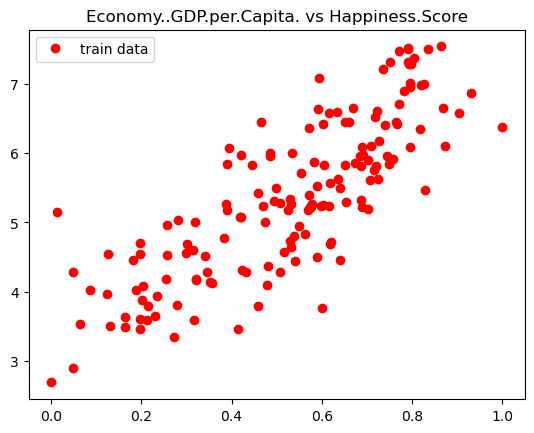

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


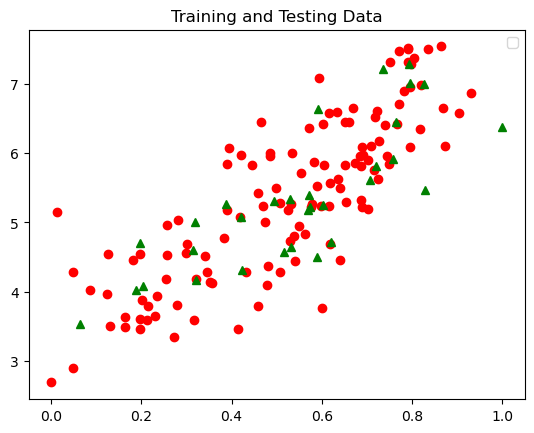

f(x)=3.157264037076431+4.219534353527542*x1
Plot the learnt mode:


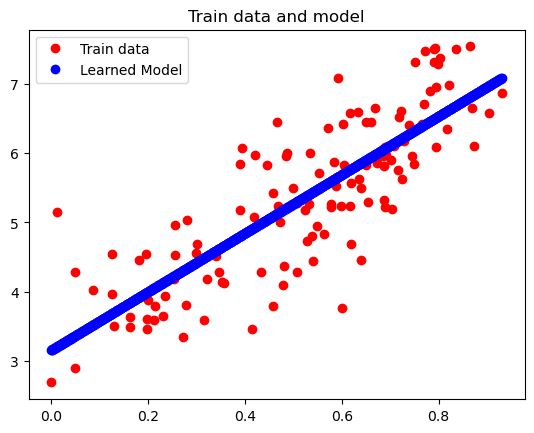

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.50537966 6.25945552 6.51142968 6.64487032 5.65491243 6.384729
 7.37679839 6.35313315 6.19523859 6.13652317 6.65708518 5.56912261
 5.39250433 5.24491923 4.79675852 5.70245409 5.58191126 5.55843229
 4.93584251 4.50204554 5.77694889 3.98824184 5.40418869 4.4805345
 5.33255718 5.64444071 4.94412853 4.5145524  4.01758557 3.94720683
 3.42576422]


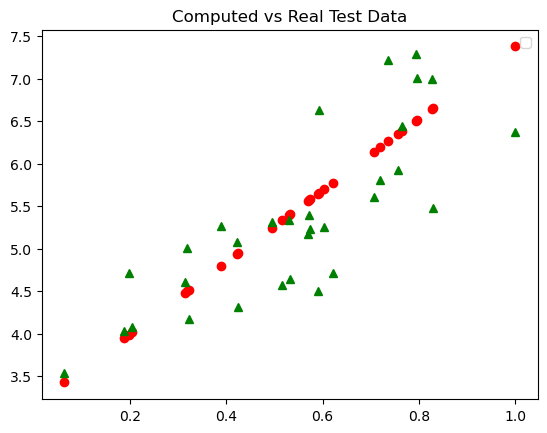

Error: 0.3725980806263176
Tool Error: 0.3725980806263176


In [96]:
linear_prediction_tool(['Economy..GDP.per.Capita.'],'Happiness.Score','v1_world-happiness-report-2017.csv')


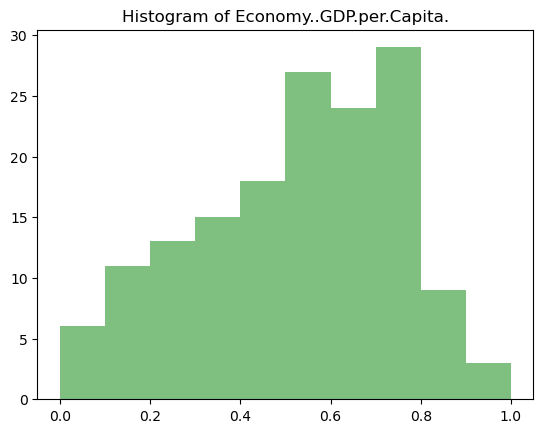

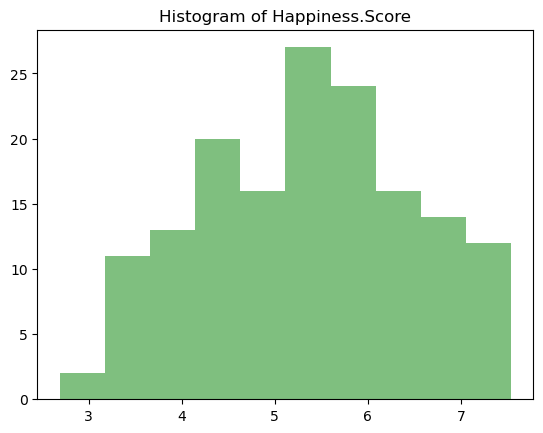

Seeing linearity betweenObjects


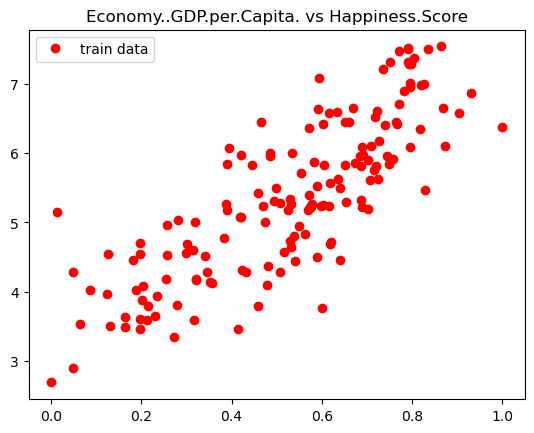

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


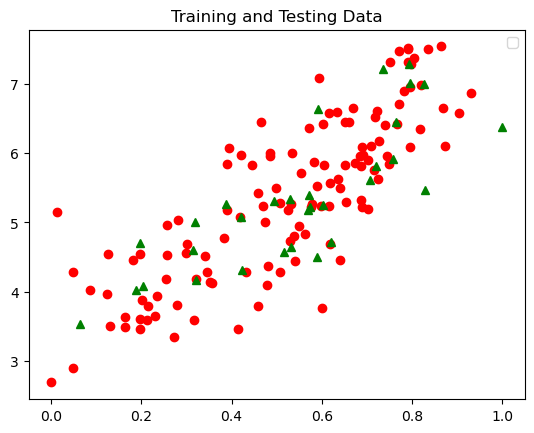

f(x)=3.157264037076431+4.219534353527542*x1
Plot the learnt mode:


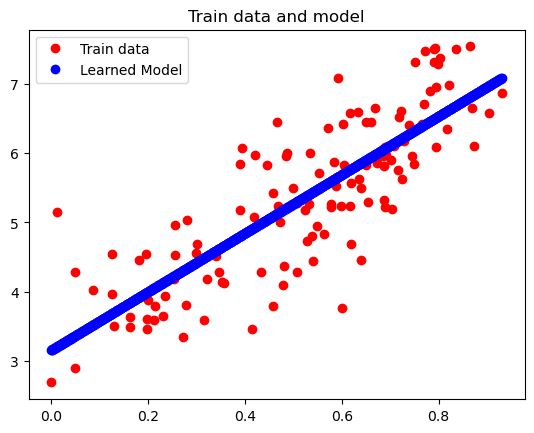

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.50537966 6.25945552 6.51142968 6.64487032 5.65491243 6.384729
 7.37679839 6.35313315 6.19523859 6.13652317 6.65708518 5.56912261
 5.39250433 5.24491923 4.79675852 5.70245409 5.58191126 5.55843229
 4.93584251 4.50204554 5.77694889 3.98824184 5.40418869 4.4805345
 5.33255718 5.64444071 4.94412853 4.5145524  4.01758557 3.94720683
 3.42576422]


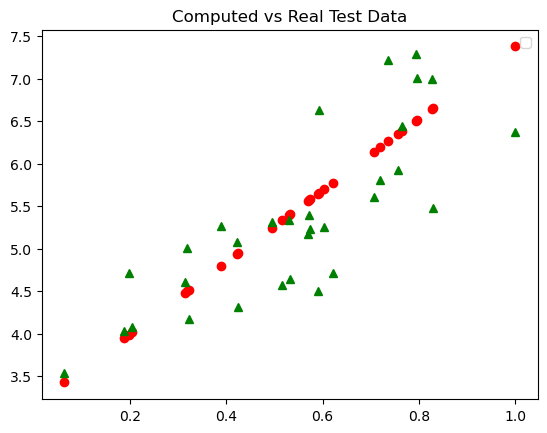

Error: 0.3725980806263176
Tool Error: 0.3725980806263176


In [97]:
linear_prediction_tool(['Economy..GDP.per.Capita.'],'Happiness.Score','v1_world-happiness-report-2017.csv')


## SELF MADE - economy

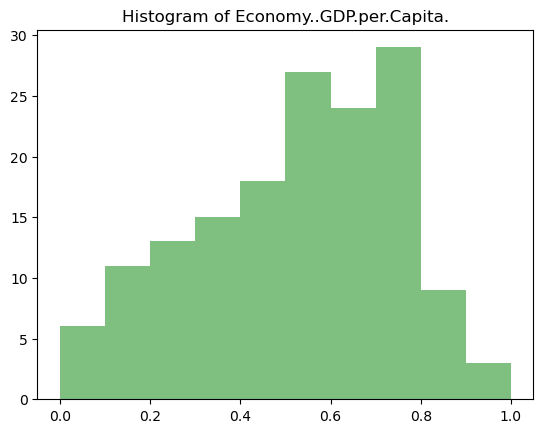

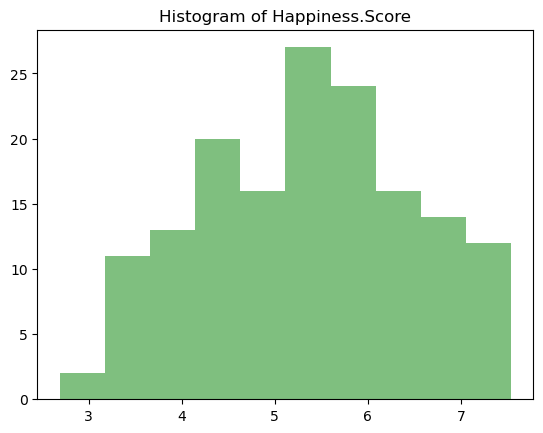

Seeing linearity betweenObjects


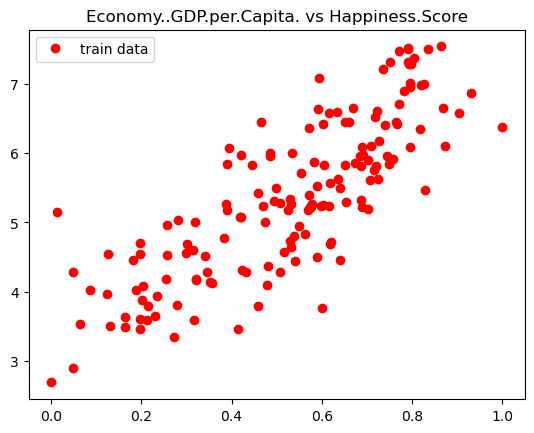

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


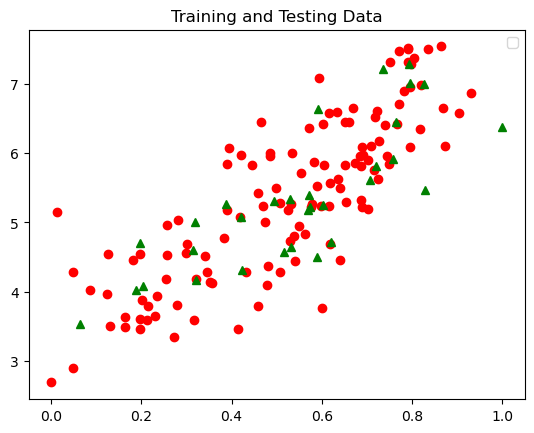

f(x)=3.157264037076431+4.219534353527542*x1
Plot the learnt mode:


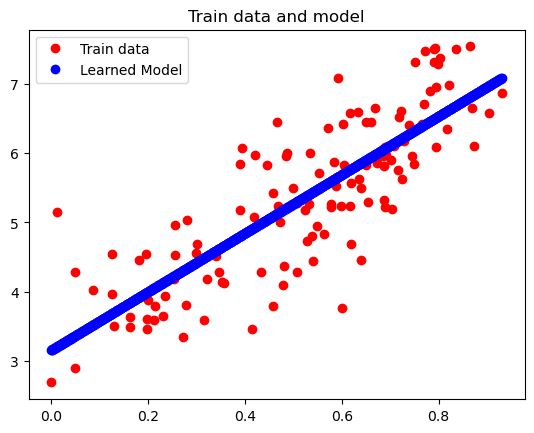

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.50537966 6.25945552 6.51142968 6.64487032 5.65491243 6.384729
 7.37679839 6.35313315 6.19523859 6.13652317 6.65708518 5.56912261
 5.39250433 5.24491923 4.79675852 5.70245409 5.58191126 5.55843229
 4.93584251 4.50204554 5.77694889 3.98824184 5.40418869 4.4805345
 5.33255718 5.64444071 4.94412853 4.5145524  4.01758557 3.94720683
 3.42576422]


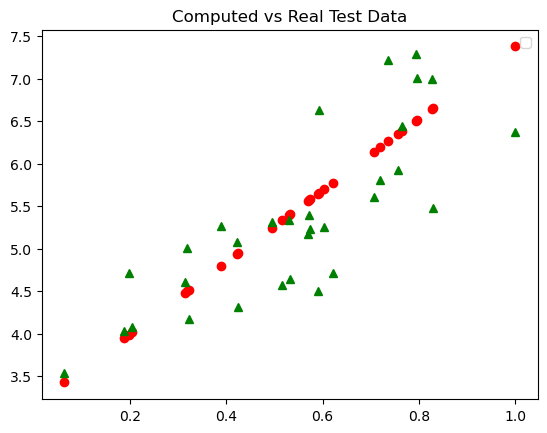

Error: 0.3725980806263176
Tool Error: 0.3725980806263176


In [98]:
linear_prediction_tool(['Economy..GDP.per.Capita.'],'Happiness.Score','v1_world-happiness-report-2017.csv','self_made')


## TOOL - family

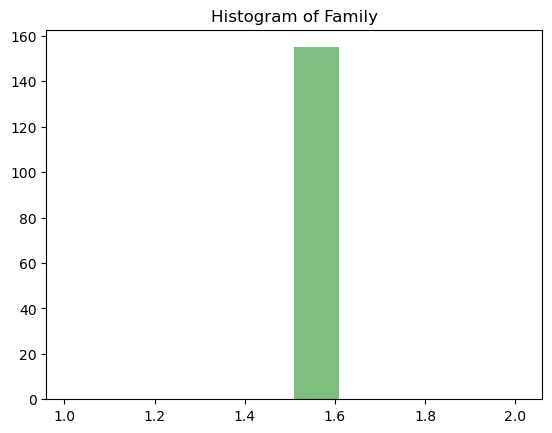

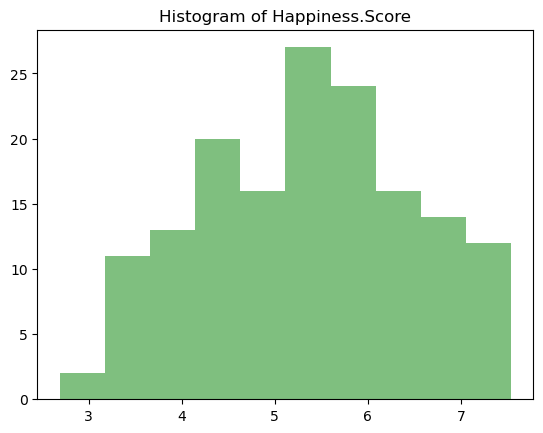

Seeing linearity betweenObjects


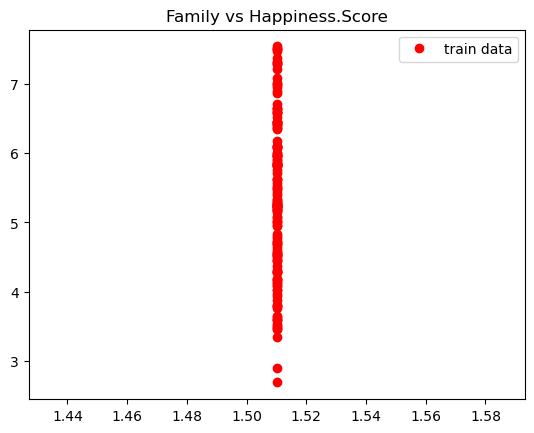

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


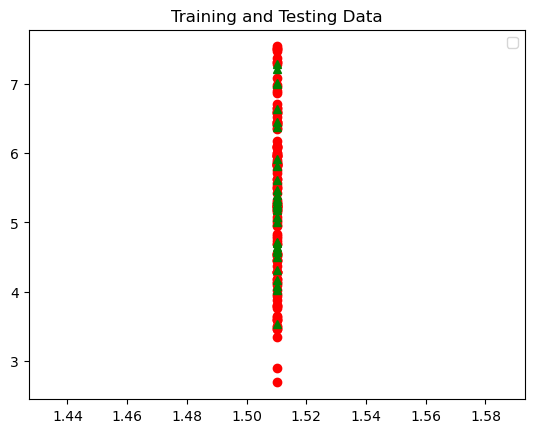

f(x)=5.185231422299266+0.11337702050410312*x1
Plot the learnt mode:


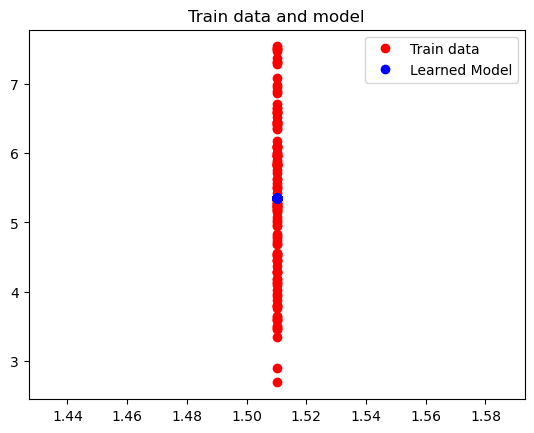

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [5.35643548 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548
 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548
 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548
 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548
 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548
 5.35643548]


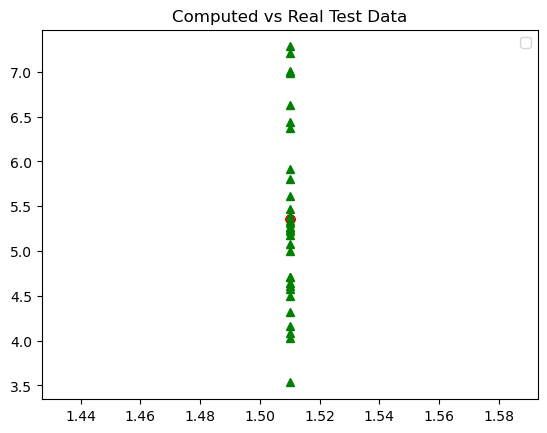

Error: 0.9594901334087325
Tool Error: 0.9594901334087325


In [99]:
linear_prediction_tool(['Family'],'Happiness.Score','v1_world-happiness-report-2017.csv')


## SELF MADE - family

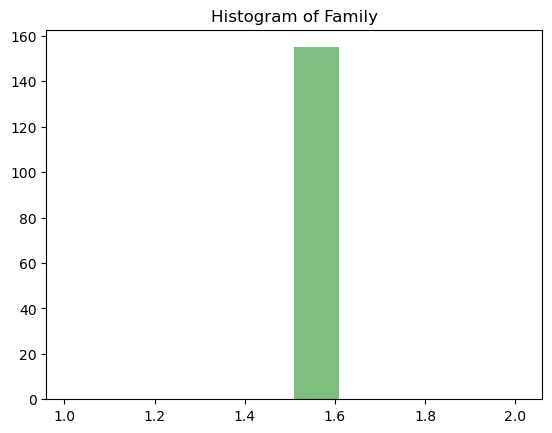

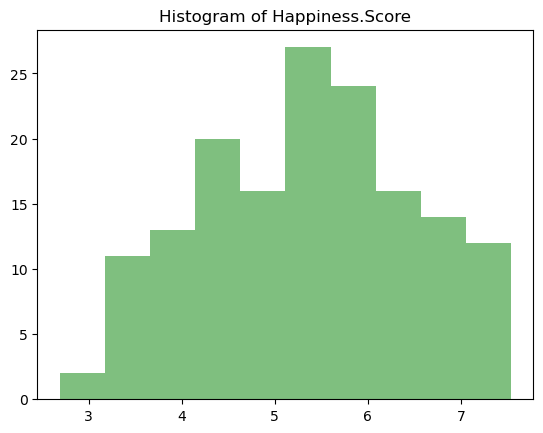

Seeing linearity betweenObjects


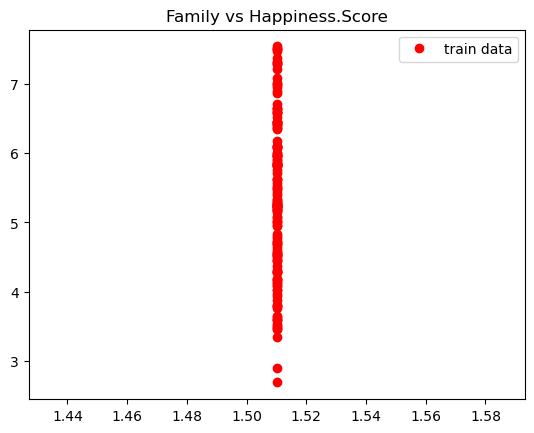

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


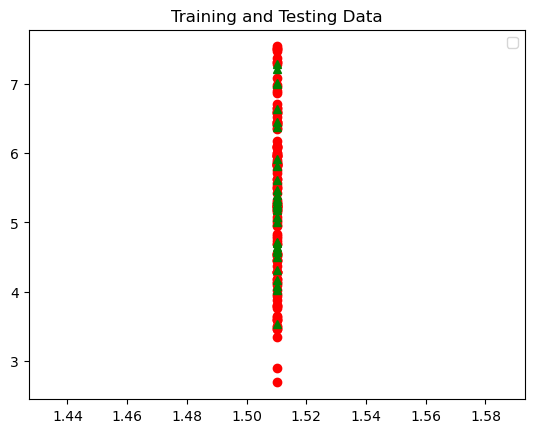

f(x)=5.185231422299266+0.11337702050410312*x1
Plot the learnt mode:


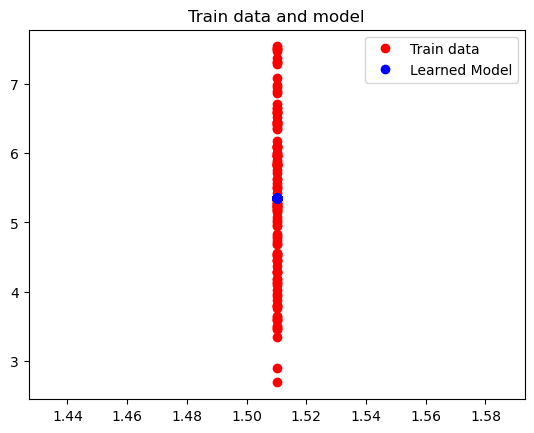

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [5.35643548 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548
 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548
 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548
 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548
 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548 5.35643548
 5.35643548]


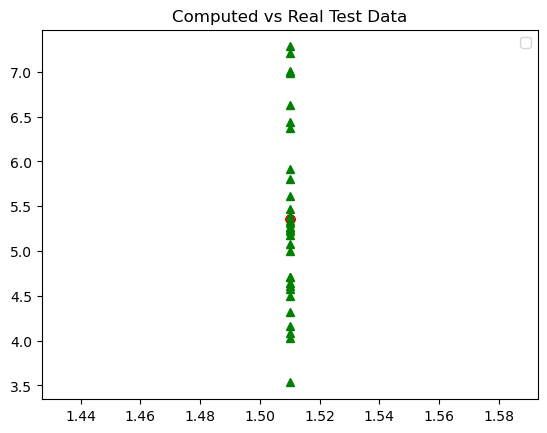

Error: 0.9594901334087325
Tool Error: 0.9594901334087325


In [100]:
linear_prediction_tool(['Family'],'Happiness.Score','v1_world-happiness-report-2017.csv','self_made')


## Tool - economy cu freedom

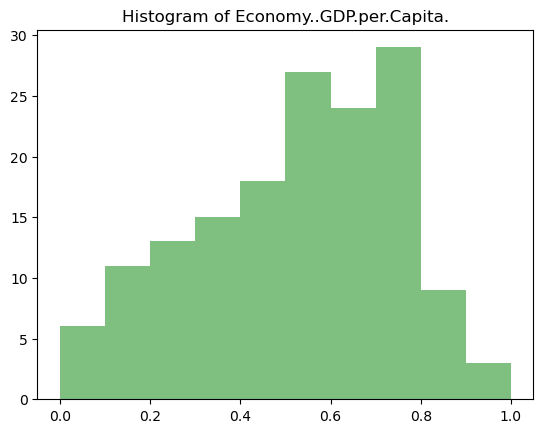

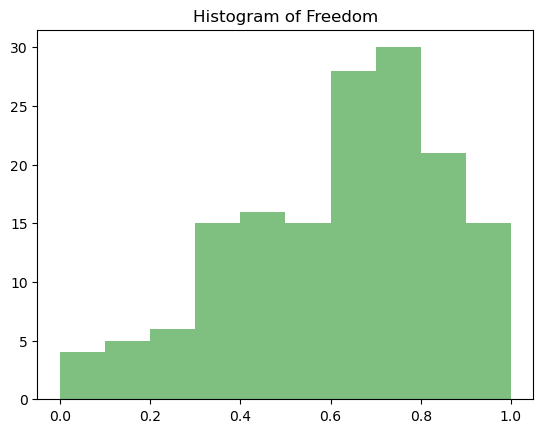

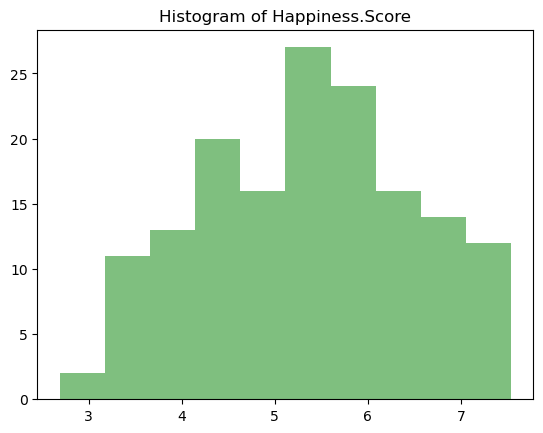

Seeing linearity betweenObjects


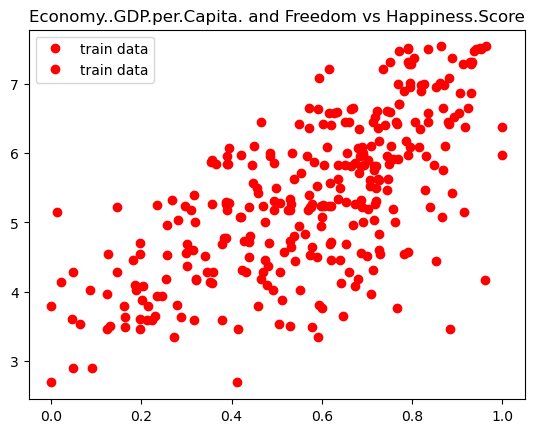

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


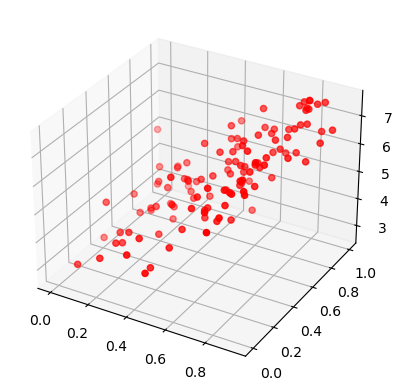

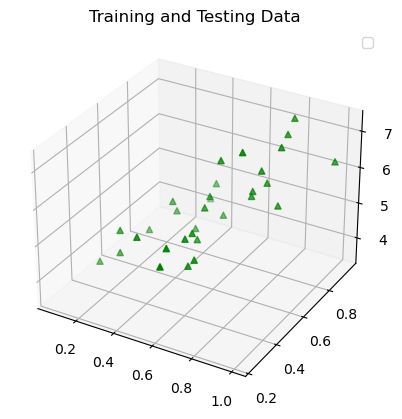

f(x)=2.4634128232842087+3.529632418175038*x1+1.7124540972799955*x2
Plot the learnt mode:


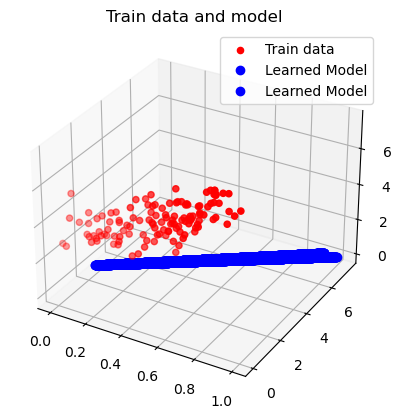

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.8292052  6.11458188 6.74622714 6.6964883  5.69074028 6.38647836
 7.56471053 6.4521516  6.23052342 6.20203251 6.66827652 5.02390776
 5.42172251 5.44365723 4.44676655 4.99308768 5.24220877 5.31983988
 5.43680896 4.77186917 5.40721938 3.98762599 5.33544141 4.81478556
 5.63662702 5.29461743 5.18080717 5.24652858 4.336032   3.96805138
 3.55401333]


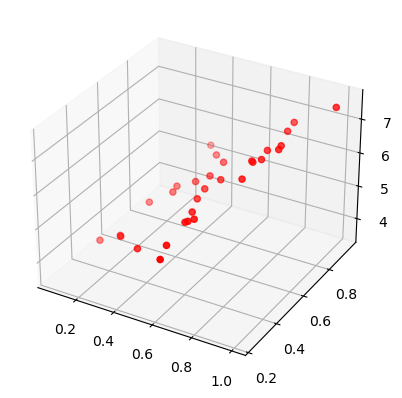

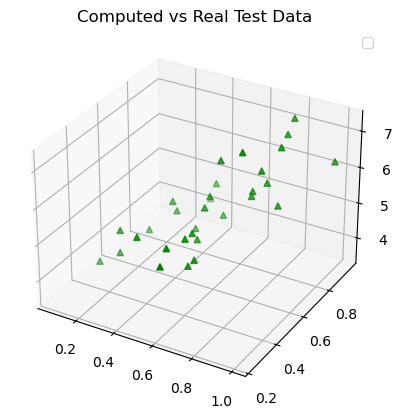

Error: 0.40323850754332896
Tool Error: 0.40323850754332896


In [101]:
linear_prediction_tool(['Economy..GDP.per.Capita.','Freedom'],'Happiness.Score','v1_world-happiness-report-2017.csv')


## Self made - pib+freedom

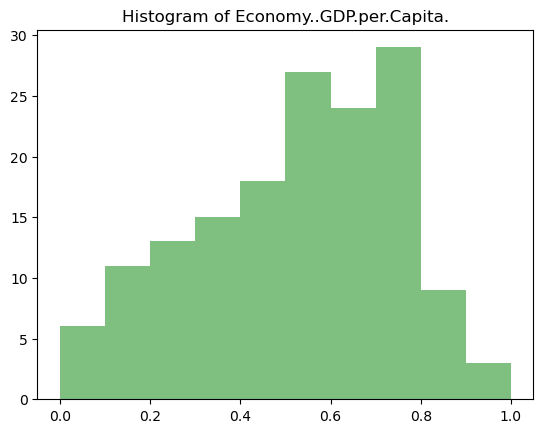

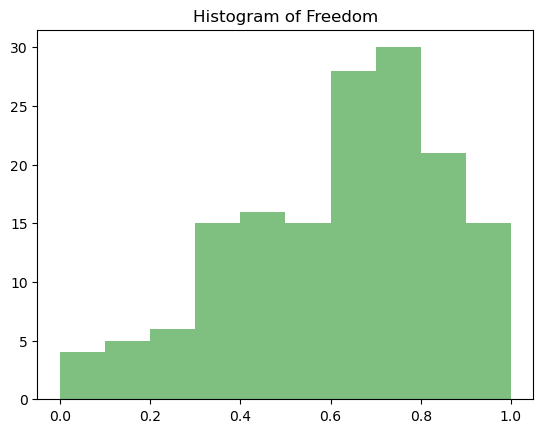

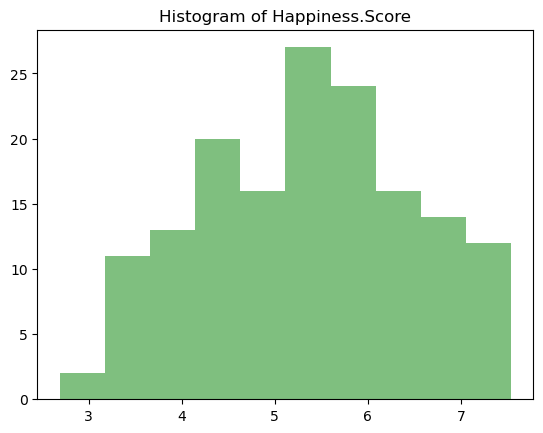

Seeing linearity betweenObjects


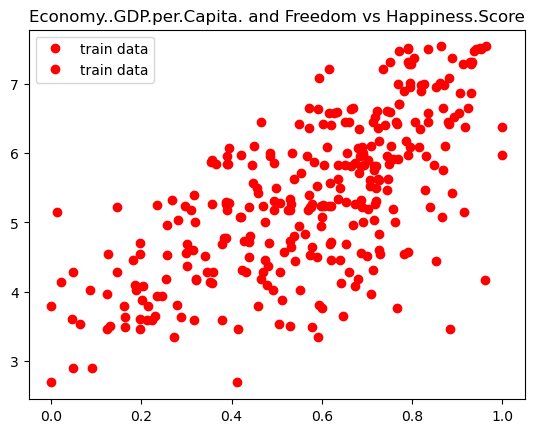

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


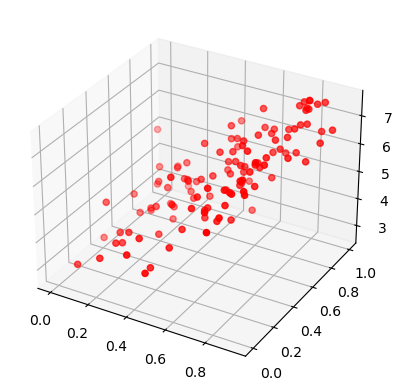

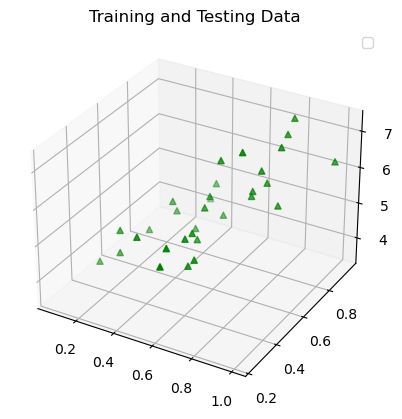

f(x)=2.4634128232842087+3.529632418175038*x1+1.7124540972799955*x2
Plot the learnt mode:


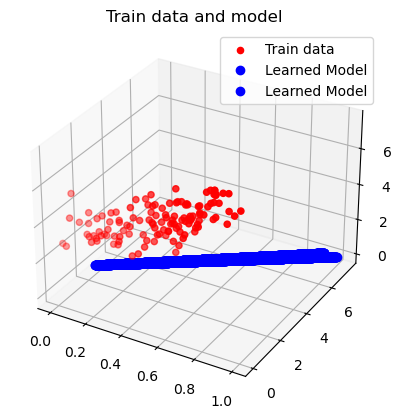

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.8292052  6.11458188 6.74622714 6.6964883  5.69074028 6.38647836
 7.56471053 6.4521516  6.23052342 6.20203251 6.66827652 5.02390776
 5.42172251 5.44365723 4.44676655 4.99308768 5.24220877 5.31983988
 5.43680896 4.77186917 5.40721938 3.98762599 5.33544141 4.81478556
 5.63662702 5.29461743 5.18080717 5.24652858 4.336032   3.96805138
 3.55401333]


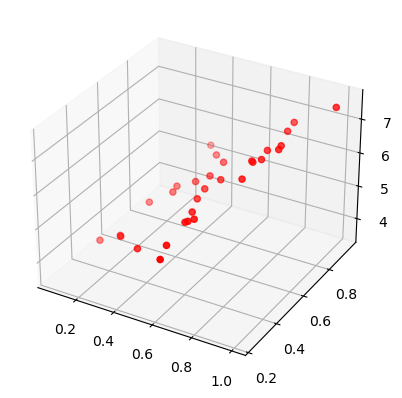

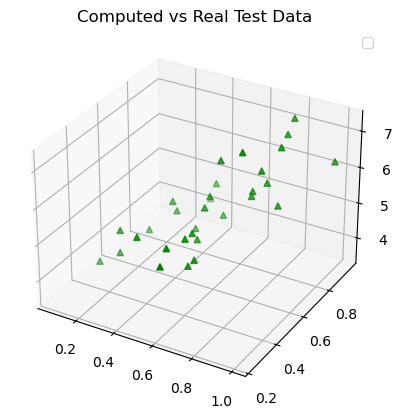

Error: 0.40323850754332896
Tool Error: 0.40323850754332896


In [102]:
linear_prediction_tool(['Economy..GDP.per.Capita.','Freedom'],'Happiness.Score','v1_world-happiness-report-2017.csv','self_made')


In [103]:
print('For file v2_world-happiness-report-2017.csv')


For file v2_world-happiness-report-2017.csv


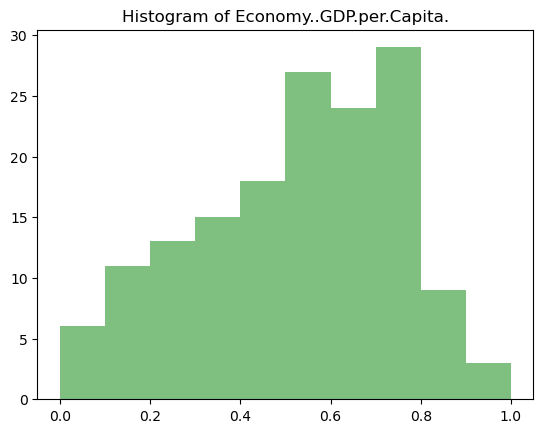

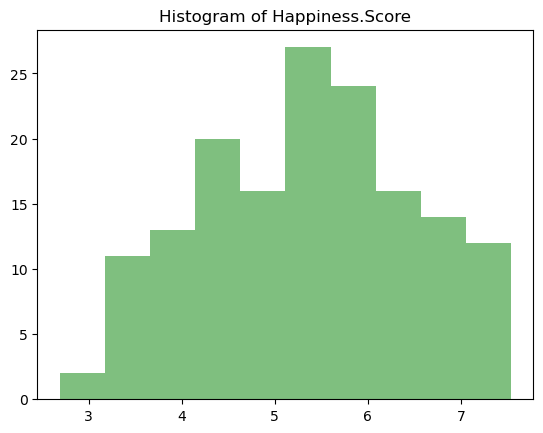

Seeing linearity betweenObjects


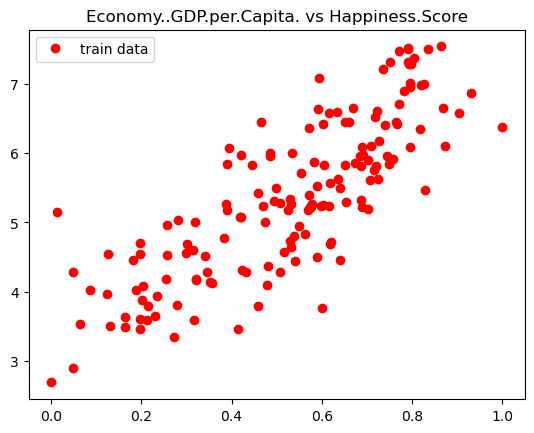

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


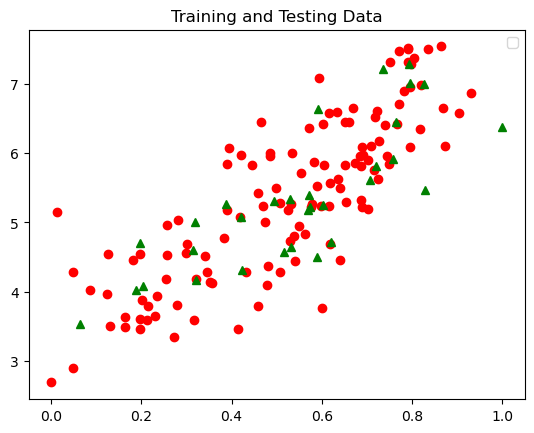

f(x)=3.157264037076431+4.219534353527542*x1
Plot the learnt mode:


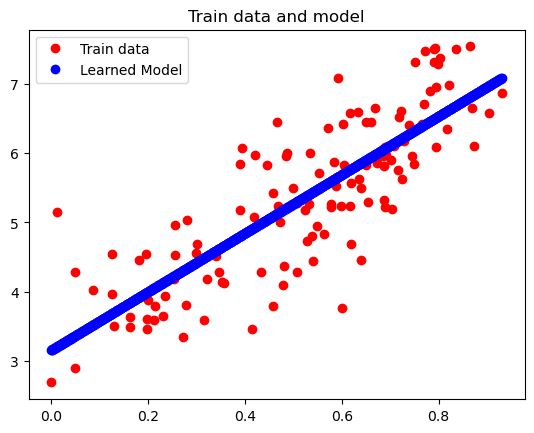

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.50537966 6.25945552 6.51142968 6.64487032 5.65491243 6.384729
 7.37679839 6.35313315 6.19523859 6.13652317 6.65708518 5.56912261
 5.39250433 5.24491923 4.79675852 5.70245409 5.58191126 5.55843229
 4.93584251 4.50204554 5.77694889 3.98824184 5.40418869 4.4805345
 5.33255718 5.64444071 4.94412853 4.5145524  4.01758557 3.94720683
 3.42576422]


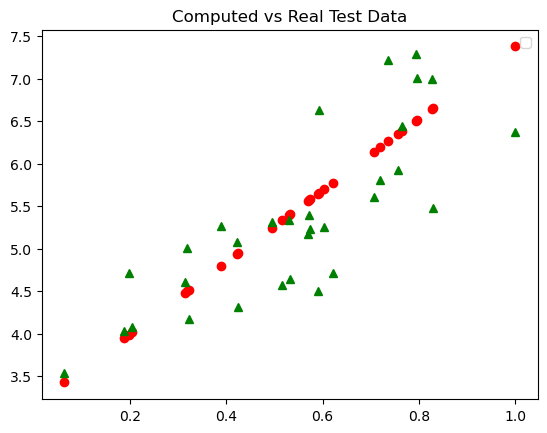

Error: 0.3725980806263176
Tool Error: 0.3725980806263176


In [104]:
linear_prediction_tool(['Economy..GDP.per.Capita.'],'Happiness.Score','v2_world-happiness-report-2017.csv')


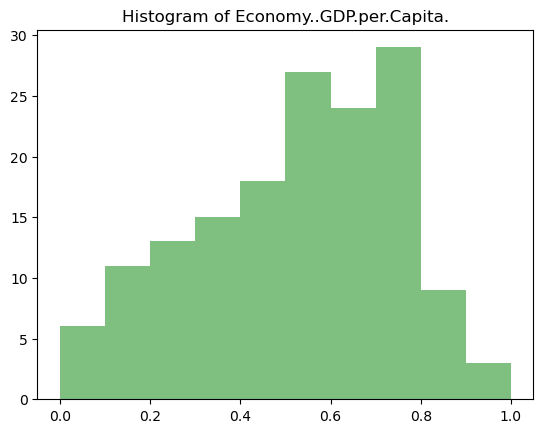

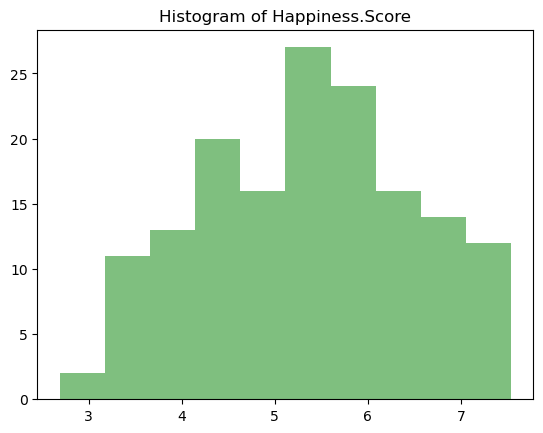

Seeing linearity betweenObjects


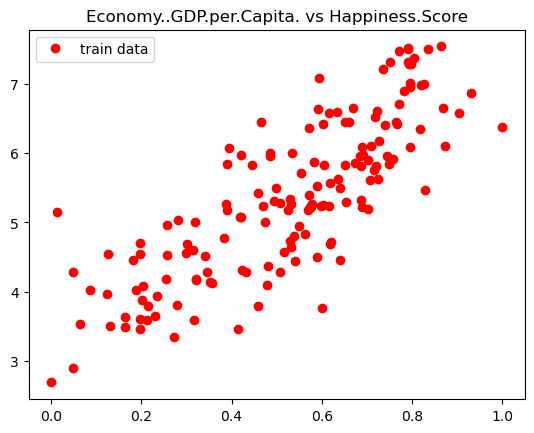

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


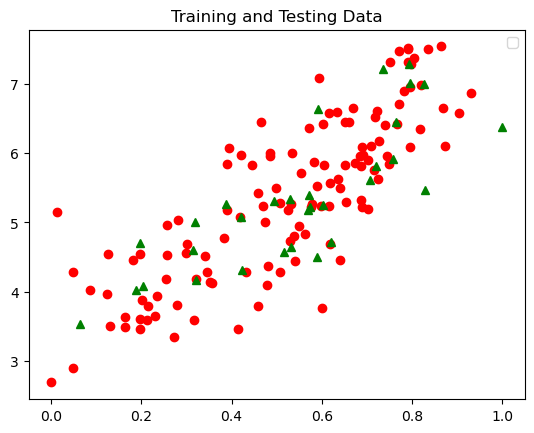

f(x)=3.157264037076431+4.219534353527542*x1
Plot the learnt mode:


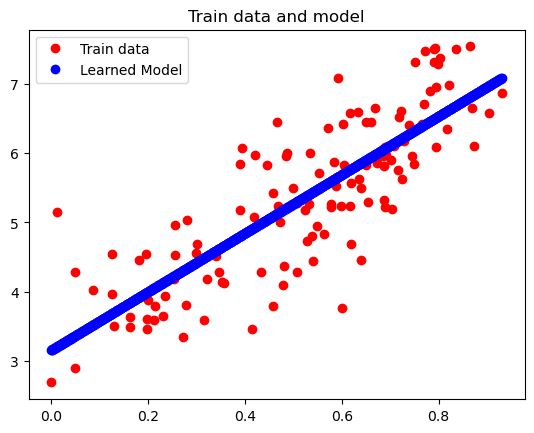

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.50537966 6.25945552 6.51142968 6.64487032 5.65491243 6.384729
 7.37679839 6.35313315 6.19523859 6.13652317 6.65708518 5.56912261
 5.39250433 5.24491923 4.79675852 5.70245409 5.58191126 5.55843229
 4.93584251 4.50204554 5.77694889 3.98824184 5.40418869 4.4805345
 5.33255718 5.64444071 4.94412853 4.5145524  4.01758557 3.94720683
 3.42576422]


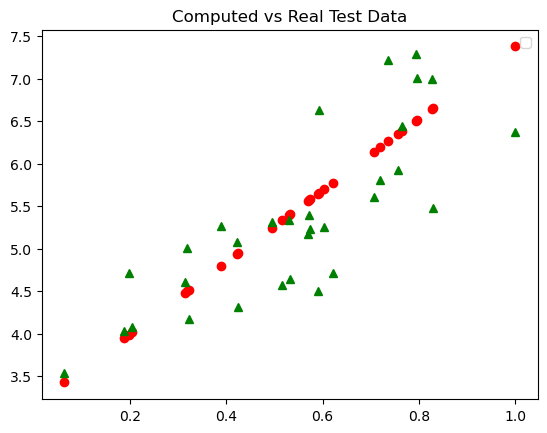

Error: 0.3725980806263176
Tool Error: 0.3725980806263176


In [105]:
linear_prediction_tool(['Economy..GDP.per.Capita.'],'Happiness.Score','v2_world-happiness-report-2017.csv','self_made')


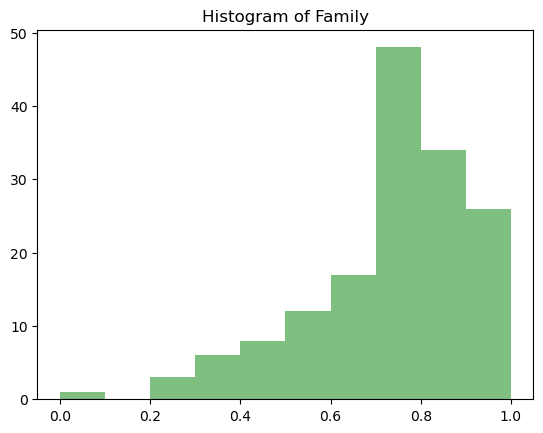

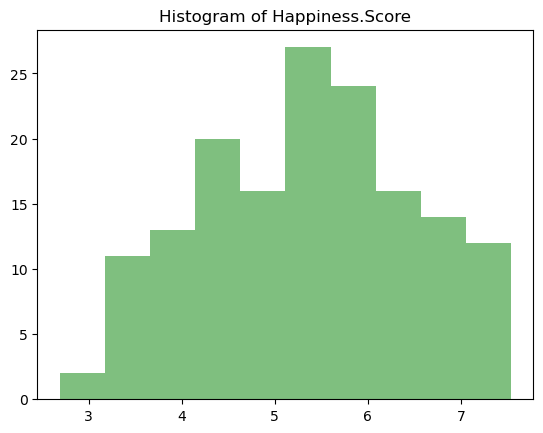

Seeing linearity betweenObjects


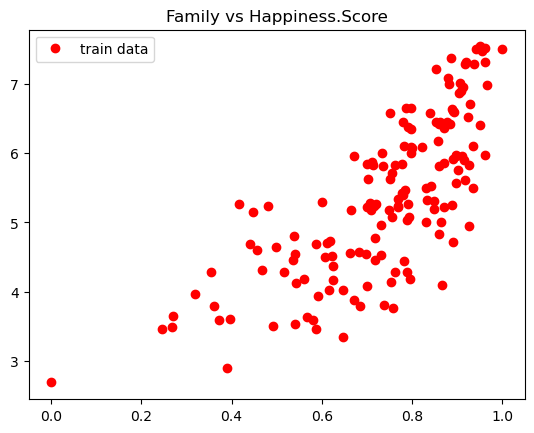

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


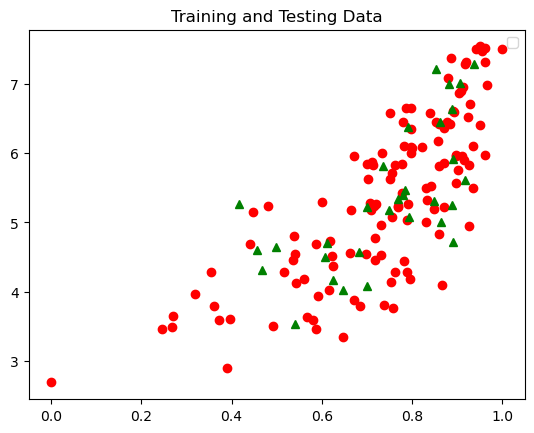

f(x)=1.7908868578008228+4.836236274060093*x1
Plot the learnt mode:


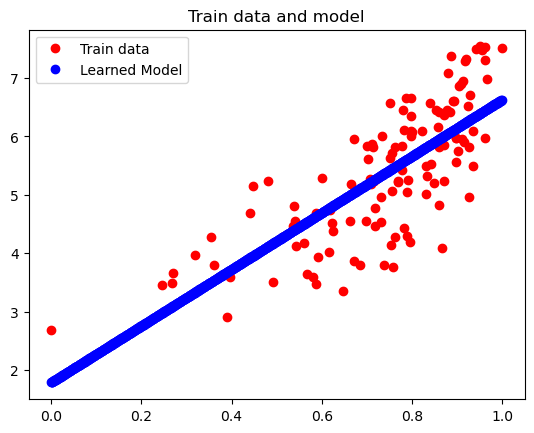

Computed: [6.32524519 5.92361433 6.1748138  6.05462842 6.08881666 5.95810719
 5.6173492  6.10392623 5.35312206 6.2250391  5.58279907 5.56898281
 5.51162656 5.89937601 3.8108444  6.08891152 5.18292581 5.41795148
 5.62694151 5.97751052 6.09804563 4.74605341 4.20419524 3.99834257
 5.08937817 4.72946939 4.05611907 4.81242225 5.18353685 4.92365107
 4.40968511]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


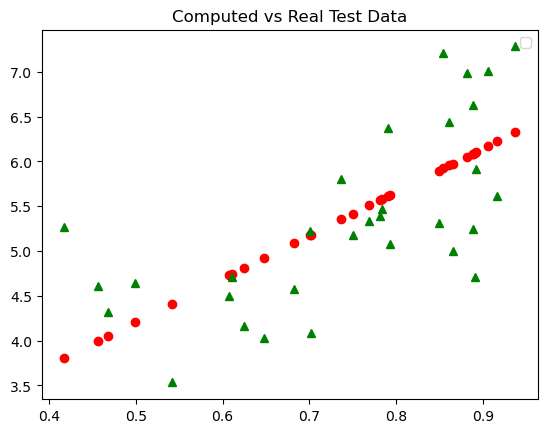

Error: 0.532461554642409
Tool Error: 0.532461554642409


In [106]:
linear_prediction_tool(['Family'],'Happiness.Score','v2_world-happiness-report-2017.csv')


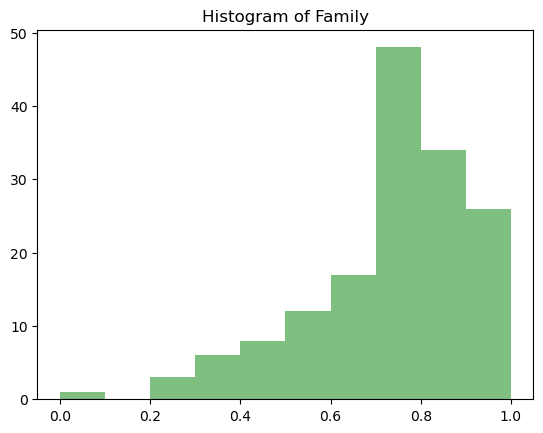

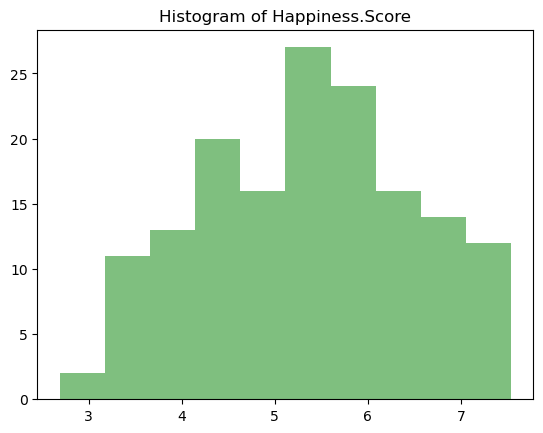

Seeing linearity betweenObjects


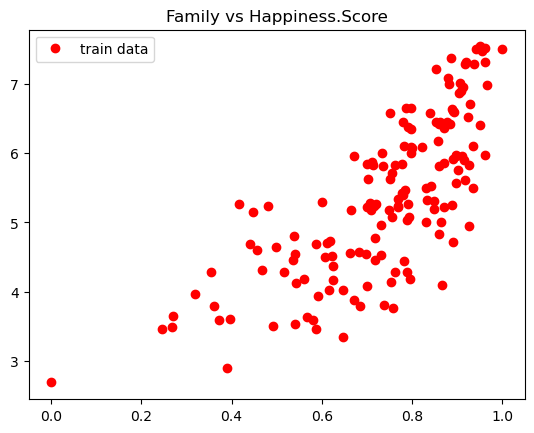

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


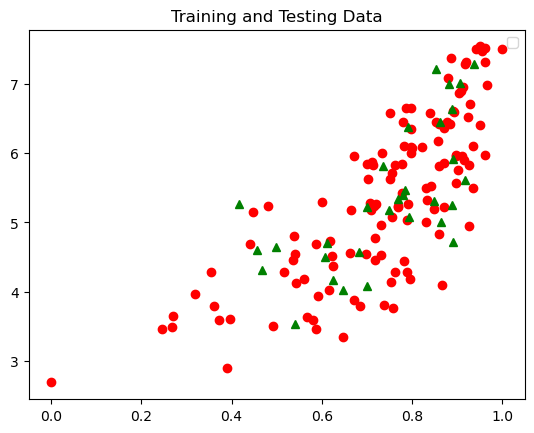

f(x)=1.7908868578008228+4.836236274060093*x1
Plot the learnt mode:


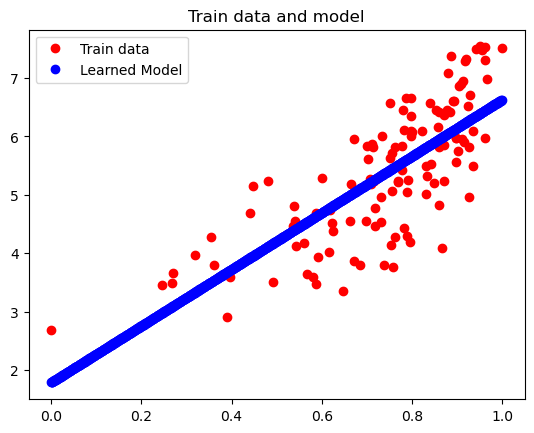

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.32524519 5.92361433 6.1748138  6.05462842 6.08881666 5.95810719
 5.6173492  6.10392623 5.35312206 6.2250391  5.58279907 5.56898281
 5.51162656 5.89937601 3.8108444  6.08891152 5.18292581 5.41795148
 5.62694151 5.97751052 6.09804563 4.74605341 4.20419524 3.99834257
 5.08937817 4.72946939 4.05611907 4.81242225 5.18353685 4.92365107
 4.40968511]


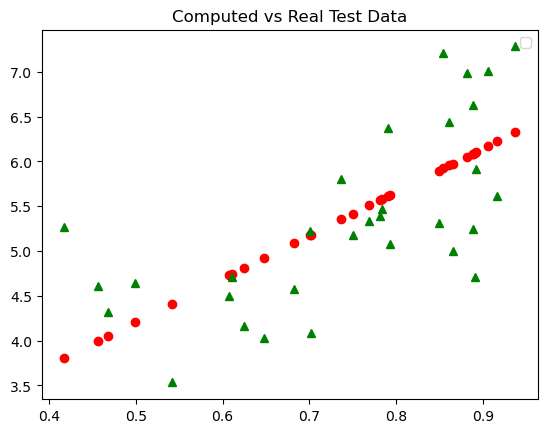

Error: 0.532461554642409
Tool Error: 0.532461554642409


In [107]:
linear_prediction_tool(['Family'],'Happiness.Score','v2_world-happiness-report-2017.csv','self_made')


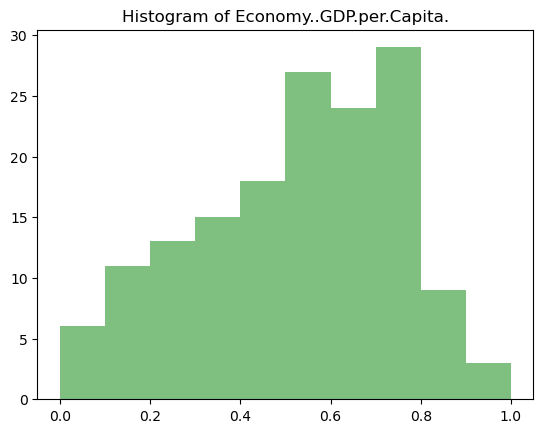

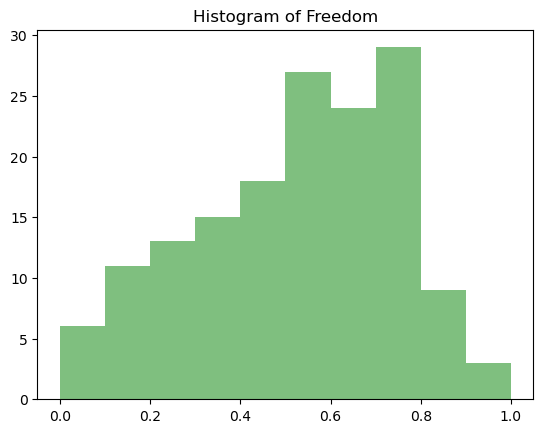

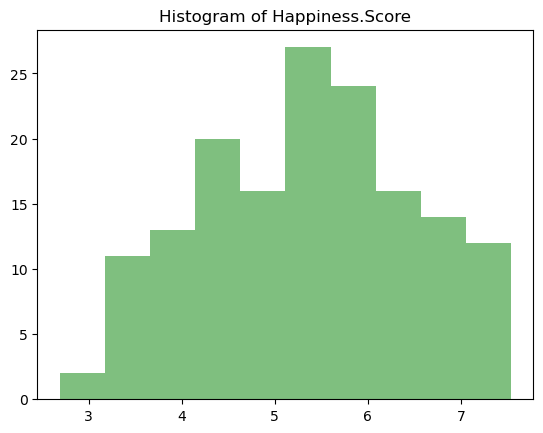

Seeing linearity betweenObjects


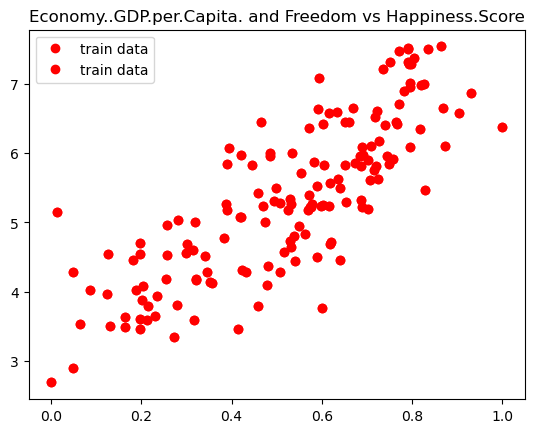

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


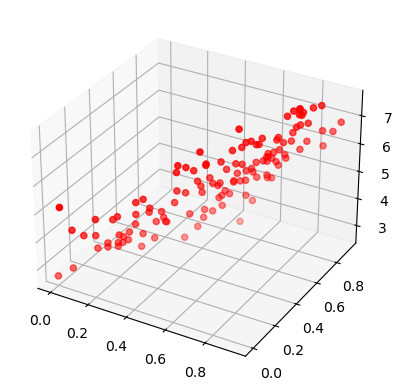

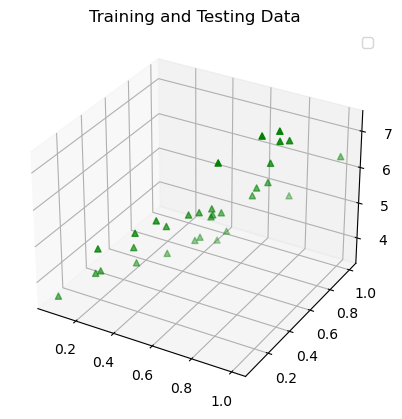

f(x)=3.1571440920803413+18969464.791922666*x1+-18969460.572471973*x2
Plot the learnt mode:


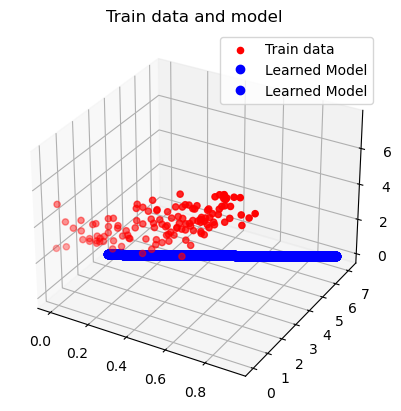

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.49505338 6.24913413 6.50110329 6.64468123 5.65474297 6.38454506
 7.37659479 6.35294984 6.18491847 6.13634415 6.66703579 5.5588149
 5.39234007 5.23461794 4.80674602 5.71242363 5.59188318 5.54812479
 4.92554736 4.50189893 5.776777   3.99824537 5.39388425 4.47024837
 5.33239411 5.63413151 4.94397315 4.51440554 4.00730862 3.94707122
 3.41549901]


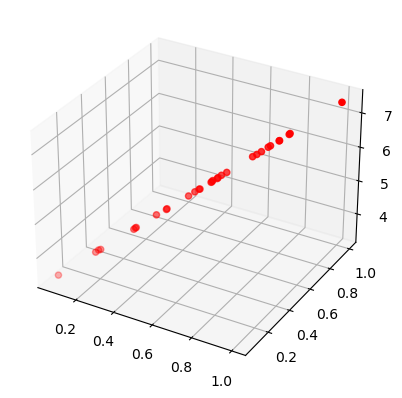

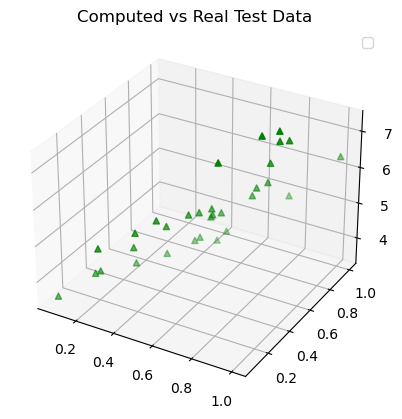

Error: 0.3730581531617084
Tool Error: 0.3730581531617084


In [108]:
linear_prediction_tool(['Economy..GDP.per.Capita.','Freedom'],'Happiness.Score','v2_world-happiness-report-2017.csv')


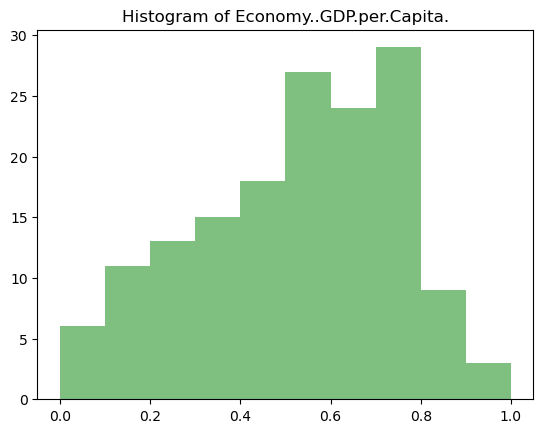

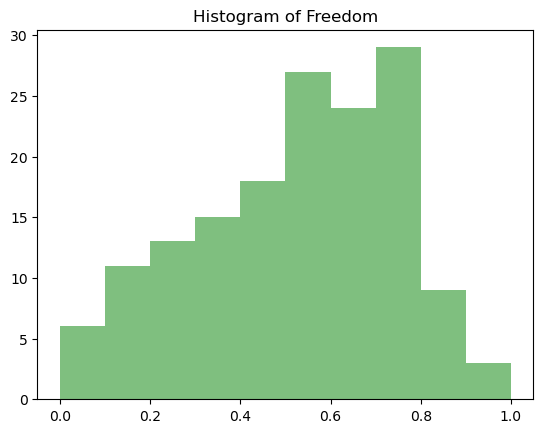

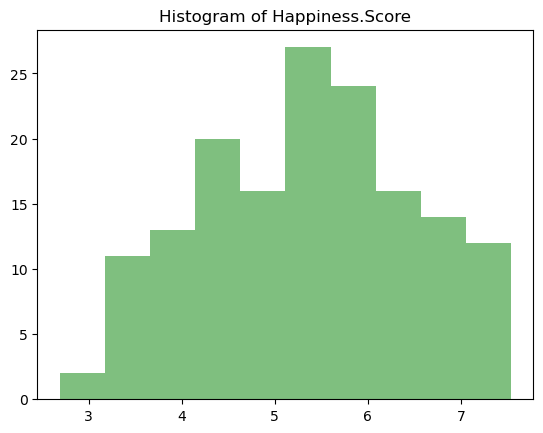

Seeing linearity betweenObjects


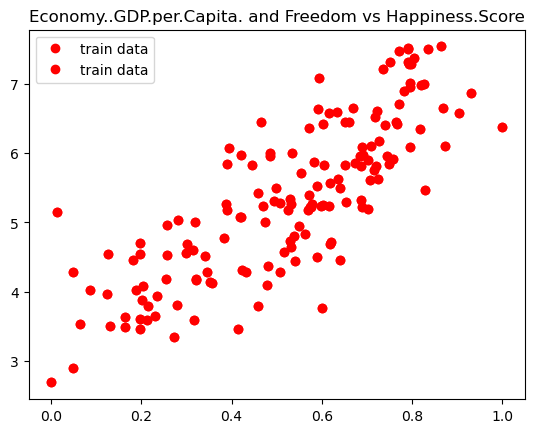

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


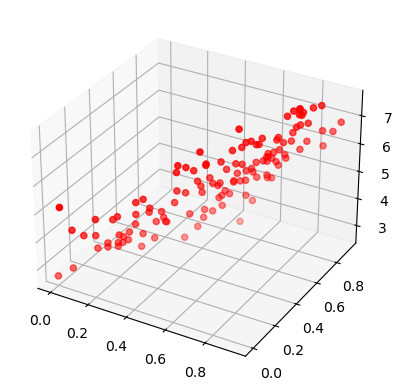

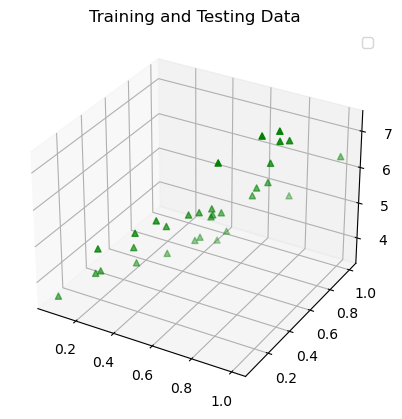

f(x)=3.1571440920803413+18969464.791922666*x1+-18969460.572471973*x2
Plot the learnt mode:


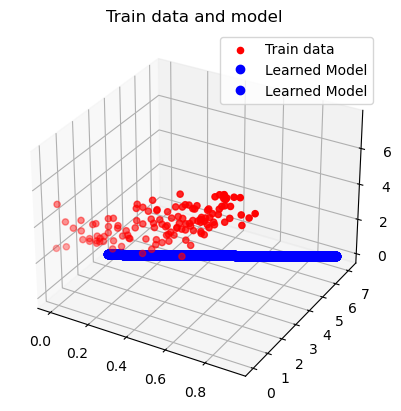

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.49505338 6.24913413 6.50110329 6.64468123 5.65474297 6.38454506
 7.37659479 6.35294984 6.18491847 6.13634415 6.66703579 5.5588149
 5.39234007 5.23461794 4.80674602 5.71242363 5.59188318 5.54812479
 4.92554736 4.50189893 5.776777   3.99824537 5.39388425 4.47024837
 5.33239411 5.63413151 4.94397315 4.51440554 4.00730862 3.94707122
 3.41549901]


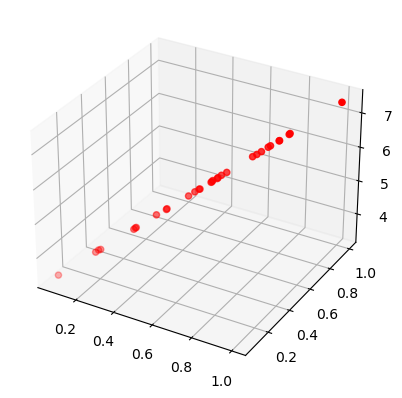

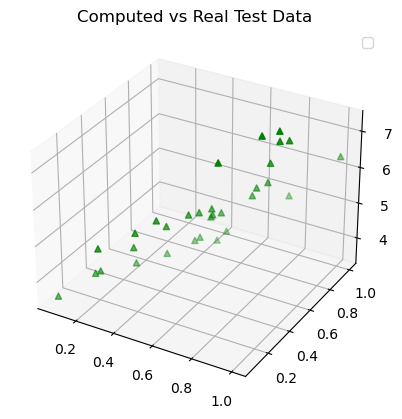

Error: 0.3730581531617084
Tool Error: 0.3730581531617084


In [109]:
linear_prediction_tool(['Economy..GDP.per.Capita.','Freedom'],'Happiness.Score','v2_world-happiness-report-2017.csv','self_made')


In [110]:
print('Self tool')


Self tool


In [111]:
print('For file v3_world-happiness-report-2017.csv')


For file v3_world-happiness-report-2017.csv


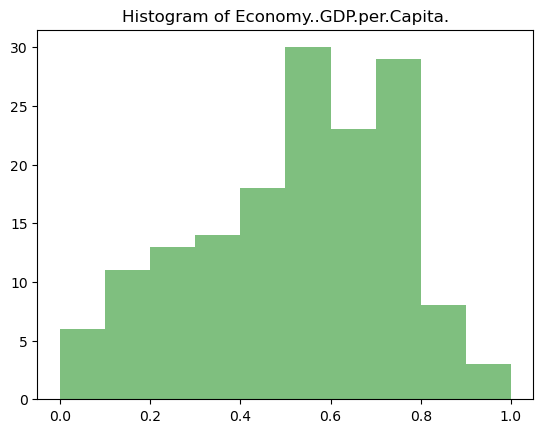

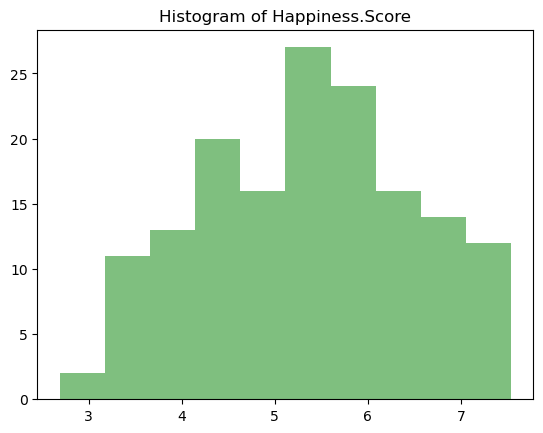

Seeing linearity betweenObjects


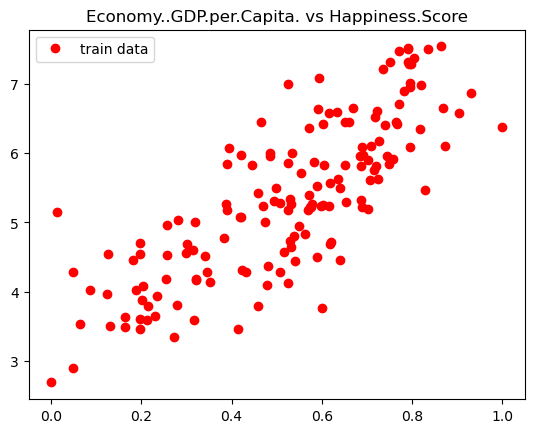

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


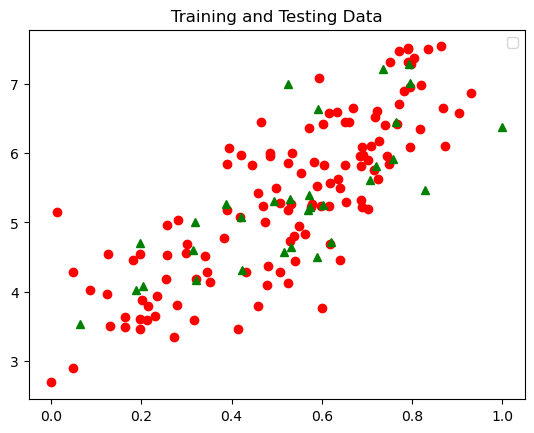

f(x)=3.16239425163293+4.208485970183518*x1
Plot the learnt mode:


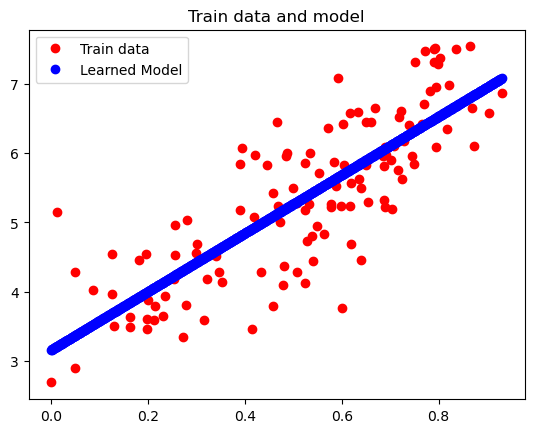

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.5017432  6.25646299 6.50777738 5.36992519 5.65350283 6.38140845
 7.37088022 6.34989533 6.1924142  6.13385252 6.6530515  5.56793764
 5.39178182 5.24458315 4.7975959  5.70092001 5.5806928  5.55727531
 4.93631572 4.50365459 5.77521975 3.99119623 5.40343558 4.48219987
 5.33199163 5.64305853 4.94458003 4.51612871 4.02046313 3.95026867
 3.4301914 ]


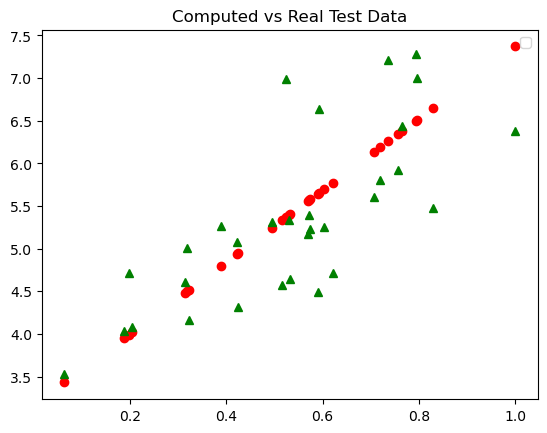

Error: 0.4526771603961269
Tool Error: 0.4526771603961269


In [112]:
linear_prediction_tool(['Economy..GDP.per.Capita.'],'Happiness.Score','v3_world-happiness-report-2017.csv')


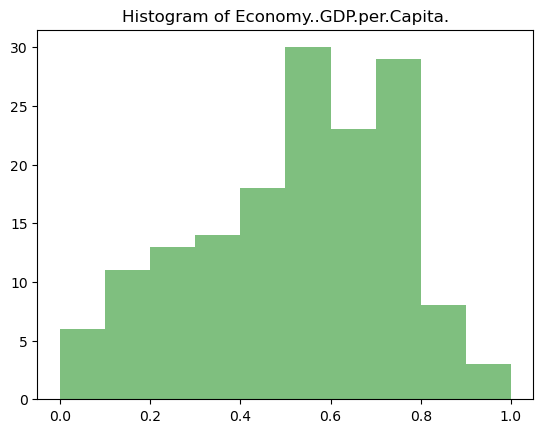

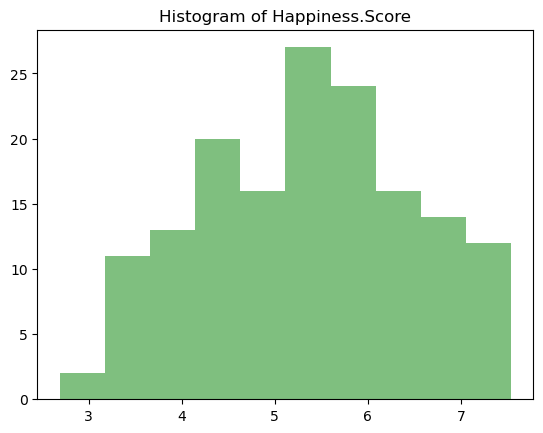

Seeing linearity betweenObjects


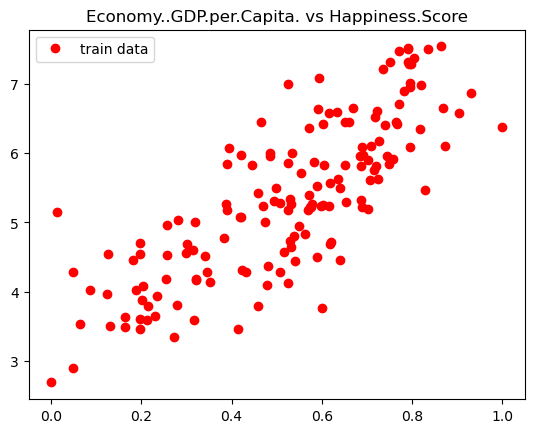

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


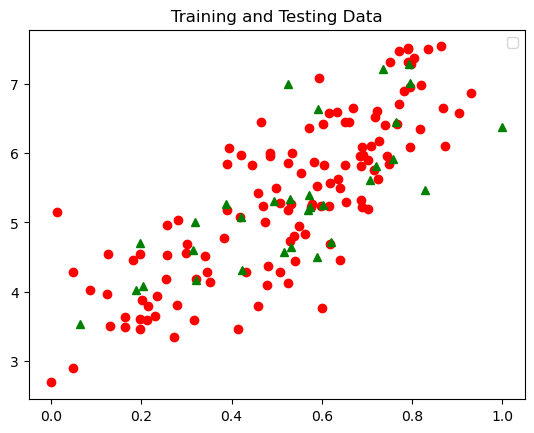

f(x)=3.16239425163293+4.208485970183518*x1
Plot the learnt mode:


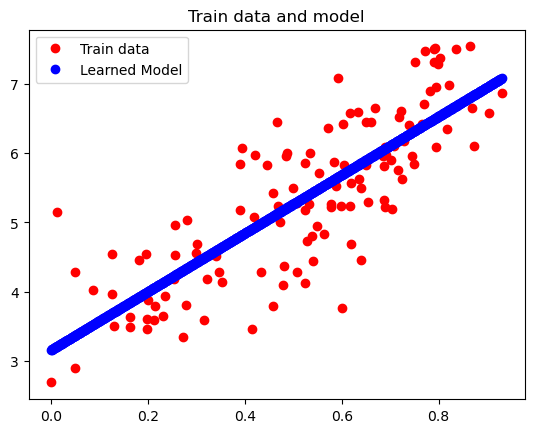

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.5017432  6.25646299 6.50777738 5.36992519 5.65350283 6.38140845
 7.37088022 6.34989533 6.1924142  6.13385252 6.6530515  5.56793764
 5.39178182 5.24458315 4.7975959  5.70092001 5.5806928  5.55727531
 4.93631572 4.50365459 5.77521975 3.99119623 5.40343558 4.48219987
 5.33199163 5.64305853 4.94458003 4.51612871 4.02046313 3.95026867
 3.4301914 ]


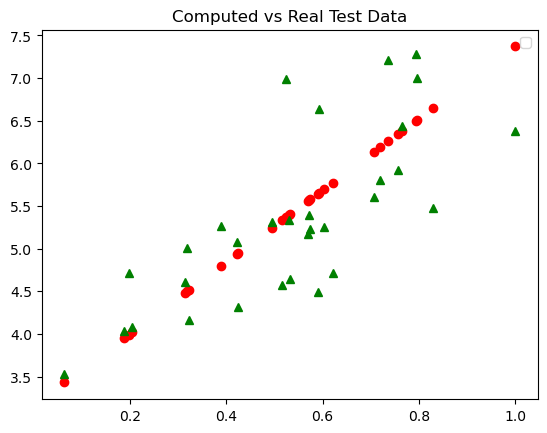

Error: 0.4526771603961269
Tool Error: 0.4526771603961269


In [113]:
linear_prediction_tool(['Economy..GDP.per.Capita.'],'Happiness.Score','v3_world-happiness-report-2017.csv','self_made')


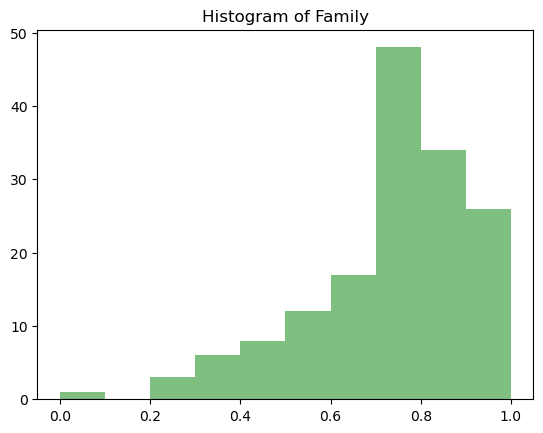

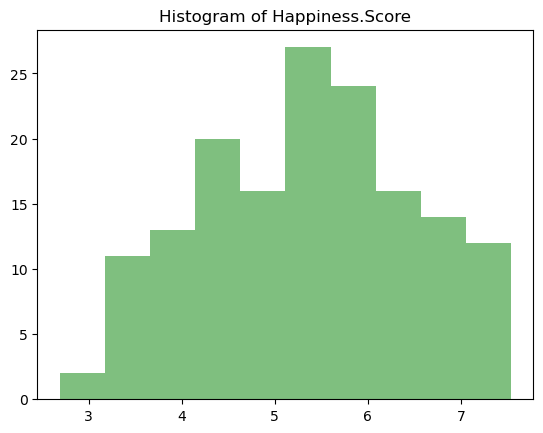

Seeing linearity betweenObjects


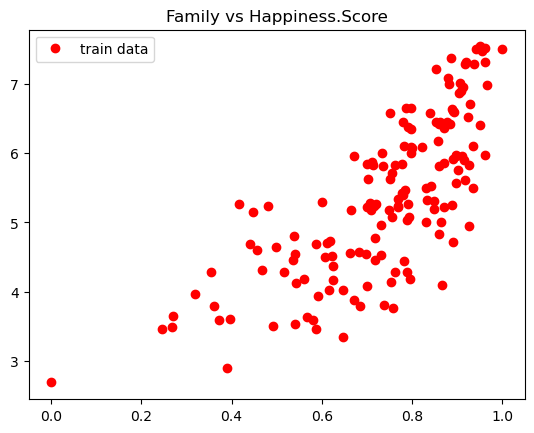

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


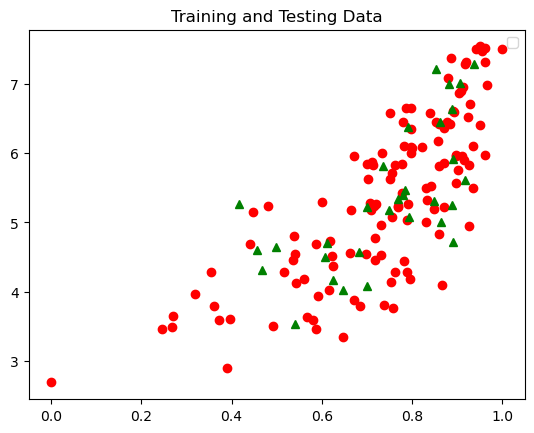

f(x)=1.7908868578008228+4.836236274060093*x1
Plot the learnt mode:


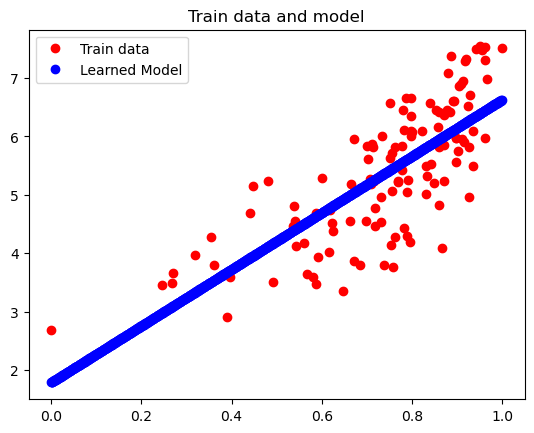

Computed: [6.32524519 5.92361433 6.1748138  6.05462842 6.08881666 5.95810719
 5.6173492  6.10392623 5.35312206 6.2250391  5.58279907 5.56898281
 5.51162656 5.89937601 3.8108444  6.08891152 5.18292581 5.41795148
 5.62694151 5.97751052 6.09804563 4.74605341 4.20419524 3.99834257
 5.08937817 4.72946939 4.05611907 4.81242225 5.18353685 4.92365107
 4.40968511]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


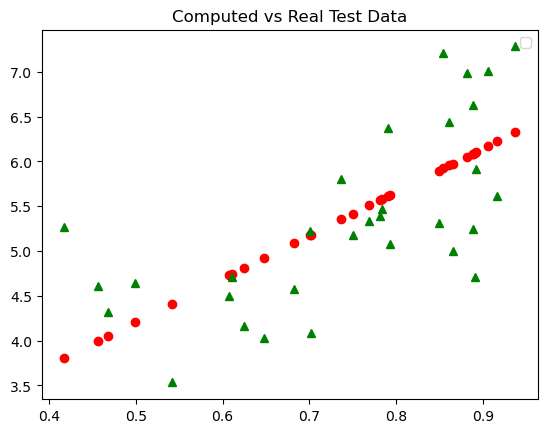

Error: 0.532461554642409
Tool Error: 0.532461554642409


In [114]:
linear_prediction_tool(['Family'],'Happiness.Score','v3_world-happiness-report-2017.csv')


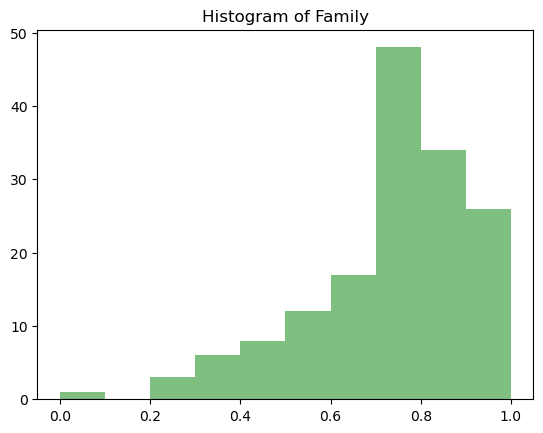

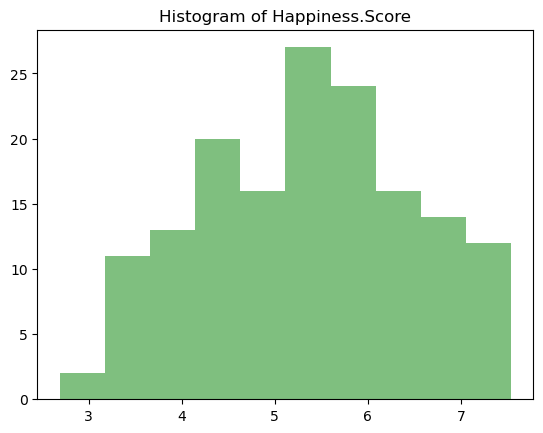

Seeing linearity betweenObjects


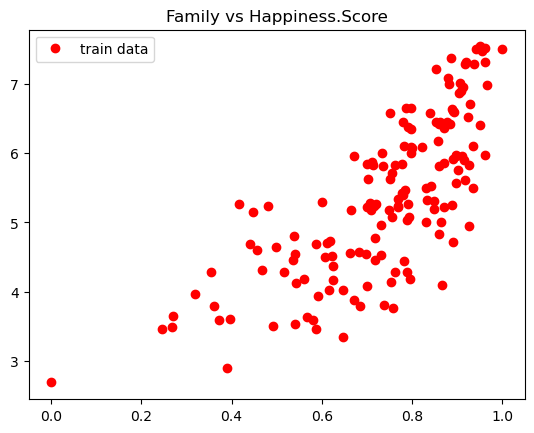

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


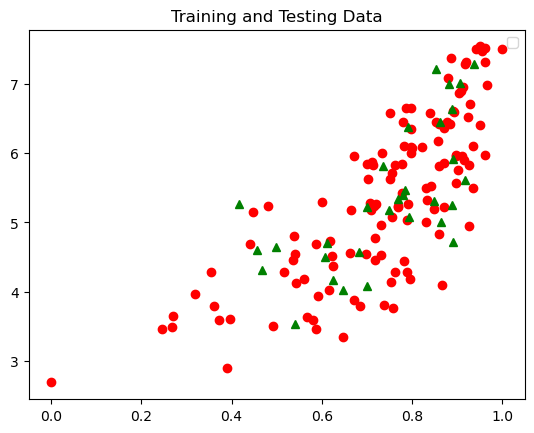

f(x)=1.7908868578008228+4.836236274060093*x1
Plot the learnt mode:


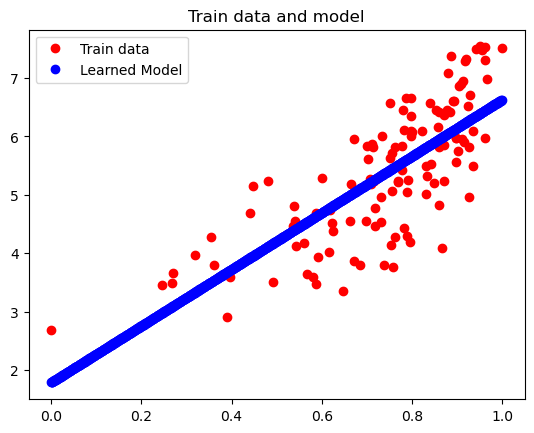

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.32524519 5.92361433 6.1748138  6.05462842 6.08881666 5.95810719
 5.6173492  6.10392623 5.35312206 6.2250391  5.58279907 5.56898281
 5.51162656 5.89937601 3.8108444  6.08891152 5.18292581 5.41795148
 5.62694151 5.97751052 6.09804563 4.74605341 4.20419524 3.99834257
 5.08937817 4.72946939 4.05611907 4.81242225 5.18353685 4.92365107
 4.40968511]


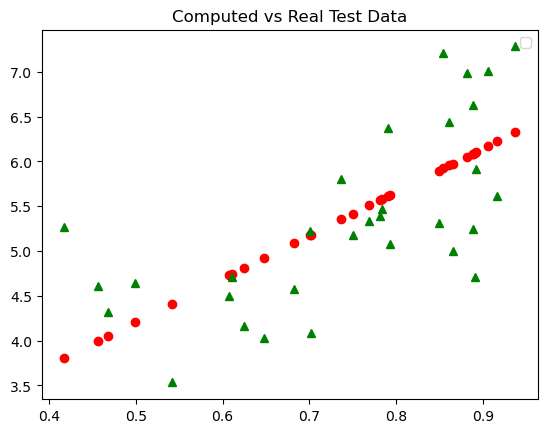

Error: 0.532461554642409
Tool Error: 0.532461554642409


In [115]:
linear_prediction_tool(['Family'],'Happiness.Score','v3_world-happiness-report-2017.csv','self_made')


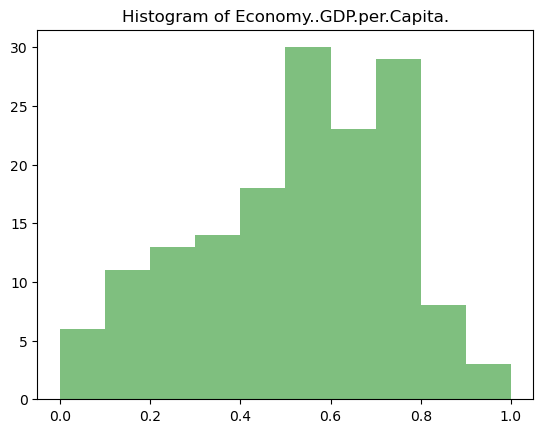

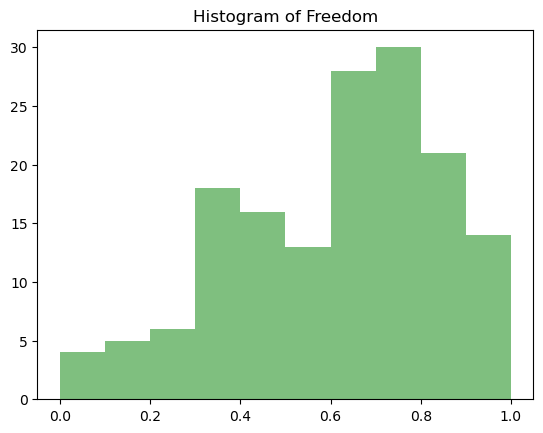

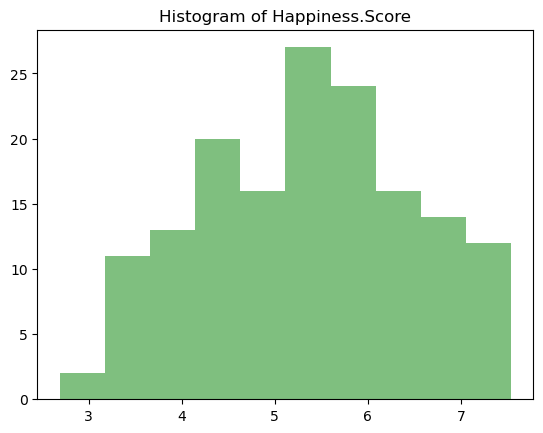

Seeing linearity betweenObjects


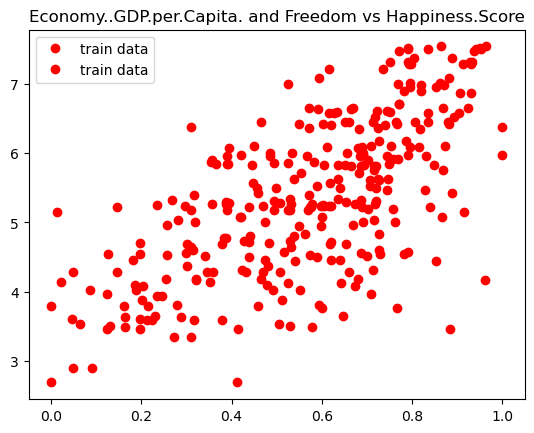

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


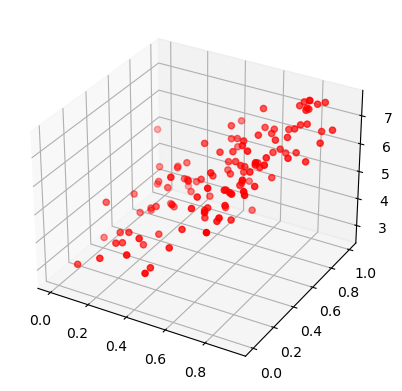

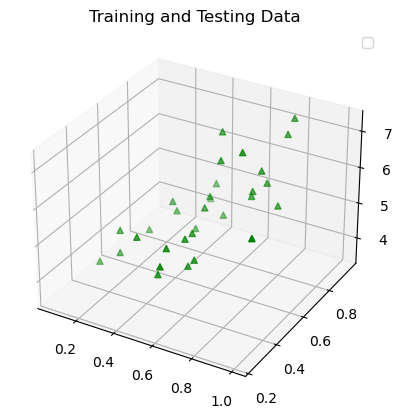

f(x)=2.475991123048299+3.4737880610410765*x1+1.744946067825924*x2
Plot the learnt mode:


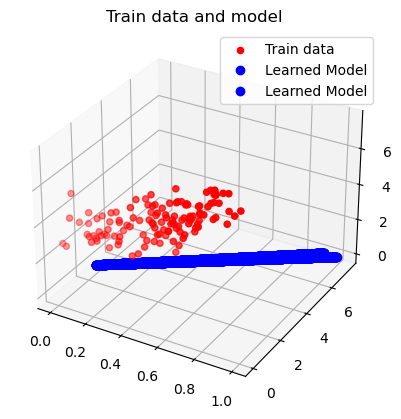

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.82716822 6.10614365 6.74243964 5.63880504 5.69185616 6.37955281
 6.49030109 6.44739177 6.22615417 6.19883167 6.65877048 5.01486824
 5.42537182 5.4520184  4.44925712 4.97958259 5.23693905 5.31672652
 5.45403629 4.78910623 5.39940372 4.00493785 4.86632379 4.83346302
 5.64609876 5.2885221  5.19293596 5.27240777 4.3591004  3.9861862
 3.57946953]


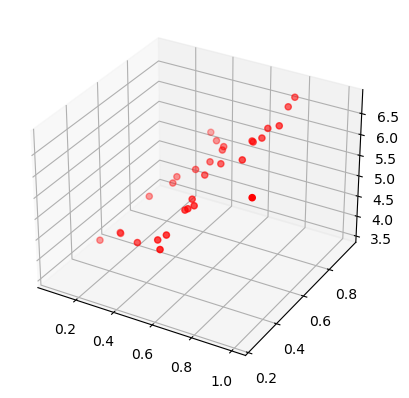

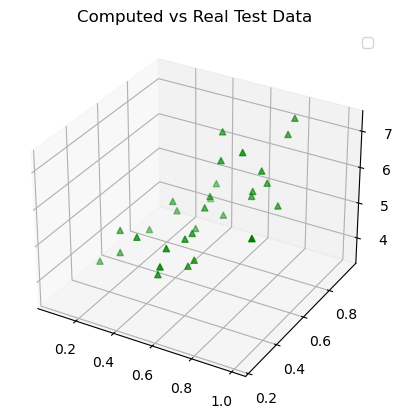

Error: 0.40294162438840764
Tool Error: 0.40294162438840764


In [116]:
linear_prediction_tool(['Economy..GDP.per.Capita.','Freedom'],'Happiness.Score','v3_world-happiness-report-2017.csv')


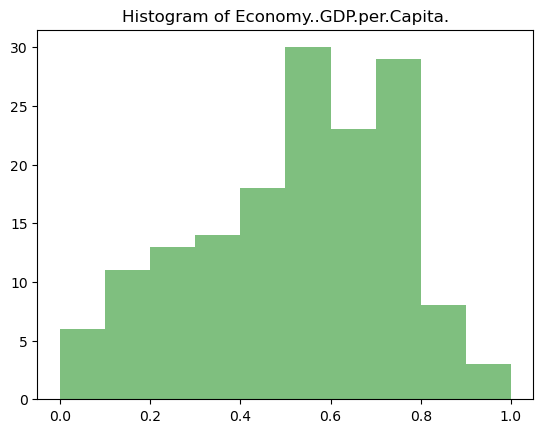

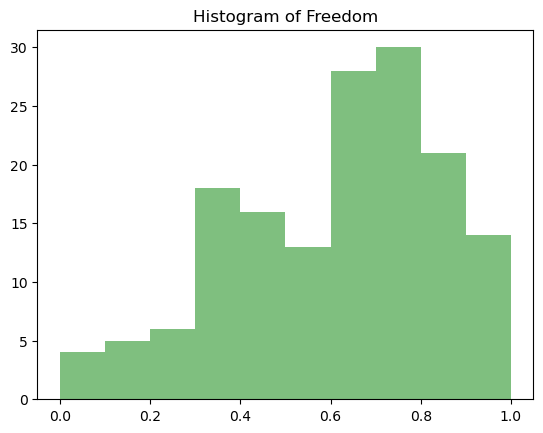

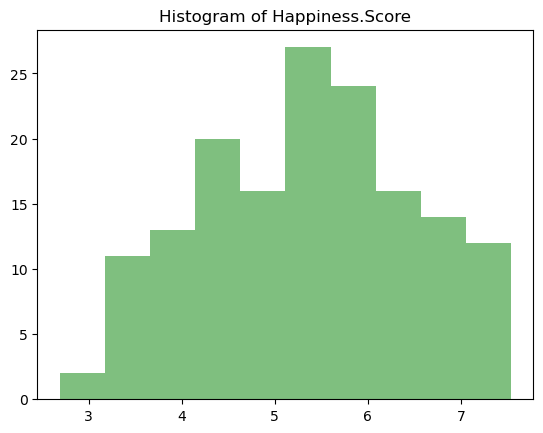

Seeing linearity betweenObjects


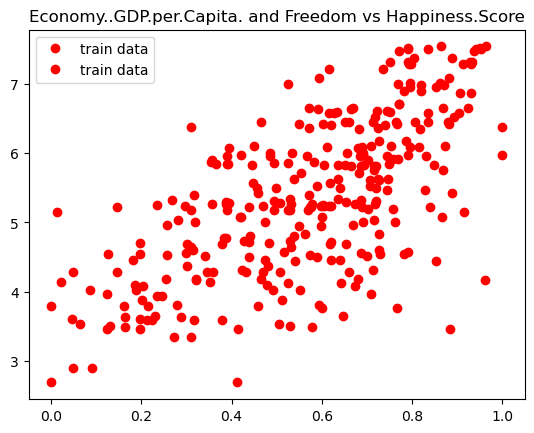

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


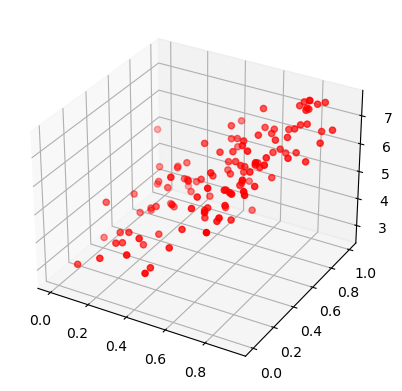

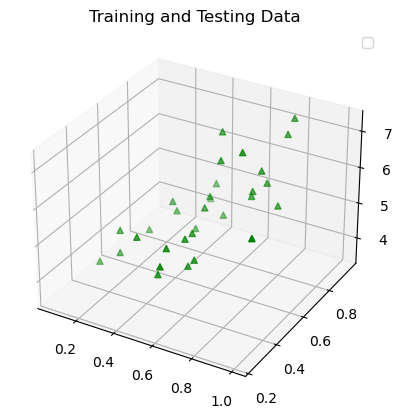

f(x)=2.475991123048299+3.4737880610410765*x1+1.744946067825924*x2
Plot the learnt mode:


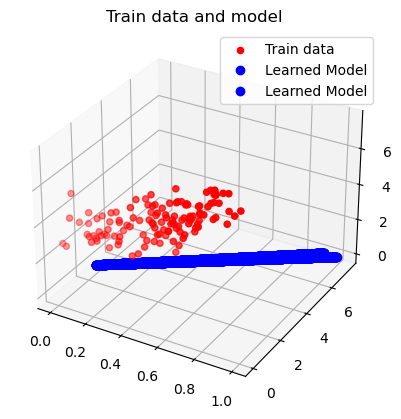

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.82716822 6.10614365 6.74243964 5.63880504 5.69185616 6.37955281
 6.49030109 6.44739177 6.22615417 6.19883167 6.65877048 5.01486824
 5.42537182 5.4520184  4.44925712 4.97958259 5.23693905 5.31672652
 5.45403629 4.78910623 5.39940372 4.00493785 4.86632379 4.83346302
 5.64609876 5.2885221  5.19293596 5.27240777 4.3591004  3.9861862
 3.57946953]


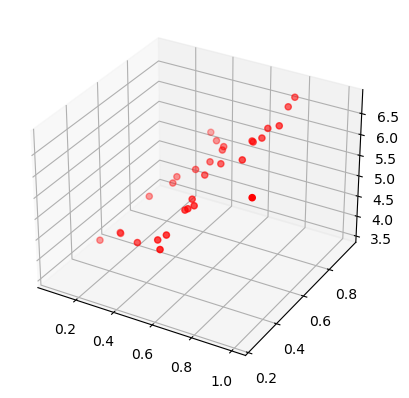

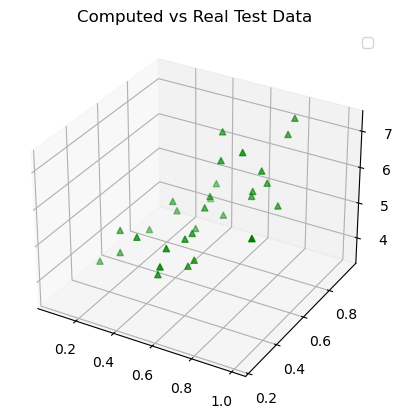

Error: 0.40294162438840764
Tool Error: 0.40294162438840764


In [117]:
linear_prediction_tool(['Economy..GDP.per.Capita.','Freedom'],'Happiness.Score','v3_world-happiness-report-2017.csv','self_made')


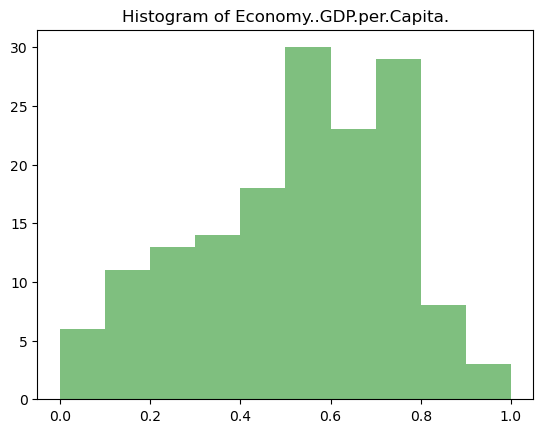

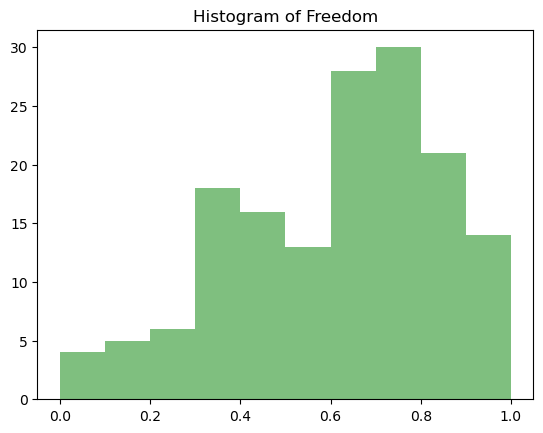

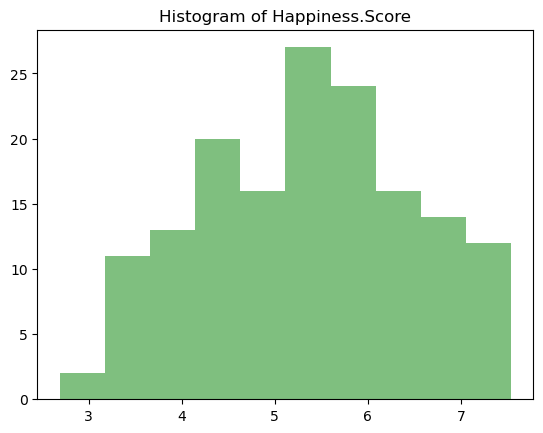

Seeing linearity betweenObjects


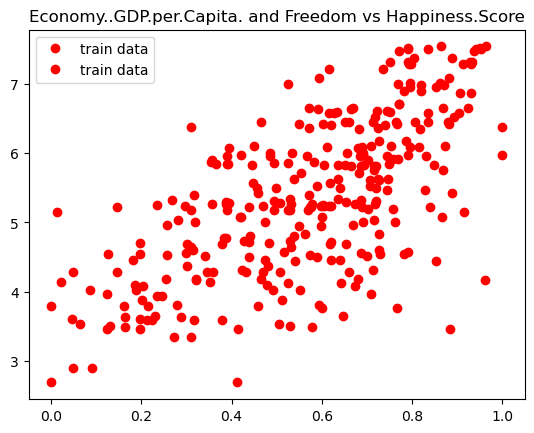

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ploating testData


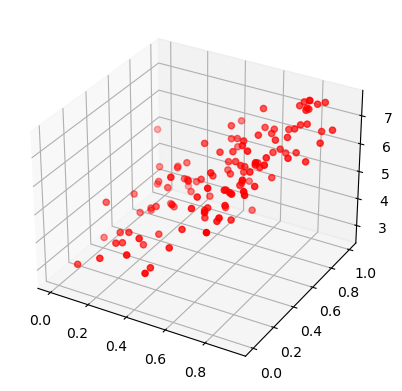

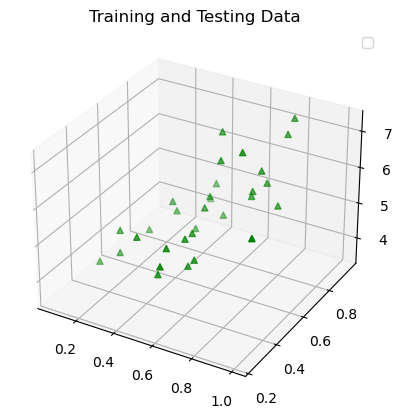

f(x)=2.475991123048299+3.4737880610410765*x1+1.744946067825924*x2
Plot the learnt mode:


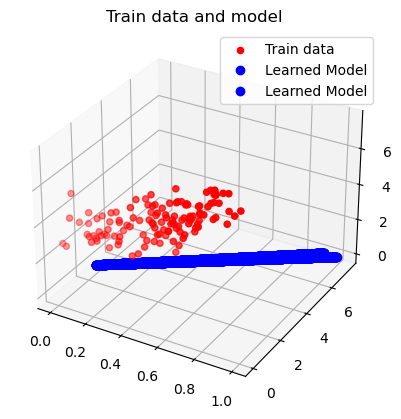

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computed: [6.82716822 6.10614365 6.74243964 5.63880504 5.69185616 6.37955281
 6.49030109 6.44739177 6.22615417 6.19883167 6.65877048 5.01486824
 5.42537182 5.4520184  4.44925712 4.97958259 5.23693905 5.31672652
 5.45403629 4.78910623 5.39940372 4.00493785 4.86632379 4.83346302
 5.64609876 5.2885221  5.19293596 5.27240777 4.3591004  3.9861862
 3.57946953]


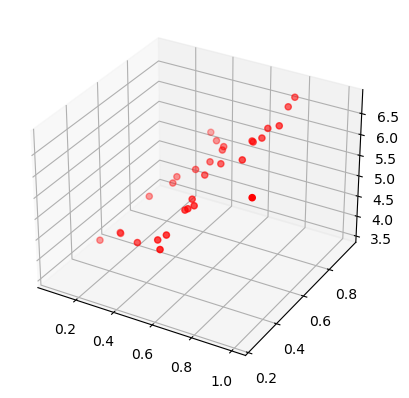

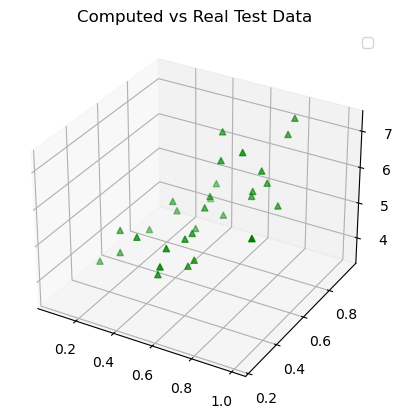

Error: 0.40294162438840764
Tool Error: 0.40294162438840764


In [118]:
linear_prediction_tool(['Economy..GDP.per.Capita.','Freedom'],'Happiness.Score','v3_world-happiness-report-2017.csv','self_made')
